# Project Overview

## OSEMN Pipeline

* O - Obtaining our data - in OS_dataset_cleanup
* S - Scrubbing/Cleaning our data - in OS_dataset_cleanup
* E - Exploring/Visualizing our data
* M - Modeling our data
* N - Interpreting the data

## Package Imports

In [42]:
# basic tools
import pandas as pd
import numpy as np
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, HalvingGridSearchCV, learning_curve, StratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.inspection import permutation_importance

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, OneSidedSelection, NeighbourhoodCleaningRule

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
#import geopandas as gpd
#from shapely.geometry import Point,Polygon
#from descartes import PolygonPatch
#from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')


## Notebook Functions

### TO DO write docstrings

In [2]:
def pipeline_fit_preprocessor(x):
    
    ''' Takes in a dataframe and adds polynomial features and scaling
    arguments: dataframe
    returns: transformed dataframe and fit pipe object'''
    
    
    # Create a column transformer to add polynomial features to Segment Number
    print("Setting up transforms - Polynomials, StandardScaler")
    poly_transforms = ColumnTransformer(transformers=[
        ("polys", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ], remainder="passthrough") 
    
    

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms1', poly_transforms),
                ('scl', StandardScaler()),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    ''' Takes in a dataframe and fit pipe object,
    and adds polynomial features and scaling
    arguments: dataframe, pipe object
    returns: transformed dataframe'''
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df


In [3]:
def spot_check_classifier(model, train, y_train, title, test, y_test):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 3 and appends model scores to the list
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 3
    scores = cross_validate(model, train, y_train, cv=3,
        scoring=('f1', 'accuracy', 'roc_auc'),
        return_train_score=True)
    f1 = round(scores['test_f1'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc'].mean()*100, 2)
    
    print("CV 3 Accuracy Train Score: {}".format(accs))
    print("CV 3 F1 Train Score: {}".format(f1))
    print("CV 3 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accs = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accs)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # append our results to our lists
    spot_check['Model'].append(title)
    spot_check['f1'].append(f1)
    spot_check['accuracy'].append(accs)
    spot_check['auc'].append(auc)
    spot_check['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}') 

In [4]:
def make_classifier(model, train, test, y_train, y_test, title):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 5 and appends model scores to the list.
    This model prints a confusion matrix and visual ROCUC. 
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 10
    scores = cross_validate(model, train, y_train, cv=10,
        scoring=('f1', 'accuracy', 'roc_auc'),
        return_train_score=True)
    f1 = round(scores['test_f1'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc'].mean()*100, 2)
    
    print("CV 10 Accuracy Train Score: {}".format(accs))
    print("CV 10 F1 Train Score: {}".format(f1))
    print("CV 10 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accuracy)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    
    # Get false positive, true positive, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # Visualize AUC
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # append our scores to our lists
    models['Model'].append(title)
    models['f1'].append(f1)
    models['accuracy'].append(accuracy)
    models['auc'].append(auc)
    models['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}')

In [5]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='roc_auc', cv=3, n_jobs=-1, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best roc_auc: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

# Exploring/Visualizing Data

In [6]:
# Load ALL Data
final = pd.read_pickle("data/pkl/train.pkl")
final

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,3,1,0,0800-0859,9,1,22,176,American Airlines Inc.,7956,...,NONE,0.00,0.0,0.0,89.0,6.71,0.191048,0.193576,0.161062,0.108412
1,4,1,0,1600-1659,6,1,24,198,United Air Lines Inc.,11588,...,NONE,1.00,0.0,0.0,70.0,19.01,0.183479,0.193576,0.238144,0.245646
2,2,1,0,1700-1759,1,5,58,90,Comair Inc.,28011,...,Douglas Municipal,0.03,0.0,0.0,56.0,4.92,0.213952,0.194913,0.229308,0.279710
3,2,3,0,0700-0759,1,1,19,143,Southwest Airlines Co.,11500,...,NONE,0.00,0.0,0.0,50.0,11.41,0.259242,0.193576,0.232799,0.106187
4,10,1,1,1100-1159,1,2,31,143,Southwest Airlines Co.,14566,...,Nashville International,0.00,0.0,0.0,79.0,3.58,0.180073,0.167245,0.164703,0.146768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577099,6,3,0,0700-0759,2,1,20,180,Delta Air Lines Inc.,6007,...,NONE,0.06,0.0,0.0,89.0,10.74,0.200541,0.193576,0.237426,0.111132
4577100,3,6,1,2000-2059,3,7,42,143,Southwest Airlines Co.,33799,...,Louis Armstrong New Orleans International,0.00,0.0,0.0,75.0,9.62,0.204318,0.172423,0.191000,0.232049
4577101,7,2,0,1500-1559,2,3,31,76,SkyWest Airlines Inc.,10124,...,Friedman Memorial,0.00,0.0,0.0,101.0,7.61,0.188983,0.193576,0.202202,0.253874
4577102,2,3,0,1600-1659,1,5,31,50,Endeavor Air Inc.,12355,...,Bangor International,0.47,0.0,0.0,46.0,10.51,0.202523,0.193576,0.232799,0.271246


In [7]:
# check distribution of target

print('Raw counts: \n')
print(final['DEP_DEL15'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DEP_DEL15'].value_counts(normalize=True))

Raw counts: 

0    3685343
1     891761
Name: DEP_DEL15, dtype: int64
-----------------------------------
Normalized counts: 

0    0.805169
1    0.194831
Name: DEP_DEL15, dtype: float64


In [8]:
# check mean values per feature on target
final.groupby('DEP_DEL15').mean()

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEP_DEL15,,,,,,,,,,,,,,,,,,,,,
0,3.806457,2.948302,27.779626,133.466159,12651.640470,63370.238410,3451.024002,1.574681e+06,7.813257e+06,0.000098,...,-94.567961,0.092285,0.023937,0.082089,71.798866,8.200483,0.192249,0.191720,0.193268,0.187156
1,3.902545,3.481995,28.253034,134.964834,13248.563454,63490.969719,3603.831333,1.645055e+06,7.820209e+06,0.000097,...,-93.110158,0.162725,0.062204,0.126227,71.949169,8.604105,0.205499,0.201248,0.201289,0.226548


Initial assessments:

* Average segment number for delay is higher
* Delays are at slightly busier airports
* Precipitation/Snow are slightly higher avg for delays

## Visualizations of delay by feature

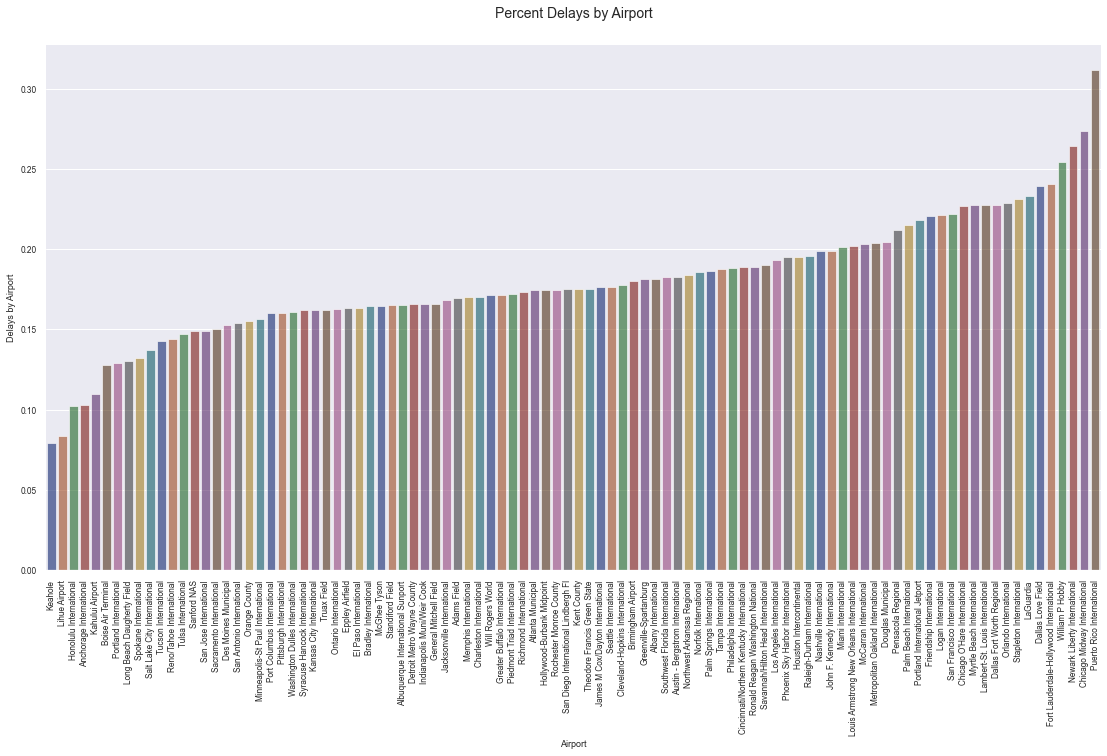

In [9]:
# Visualize delays by airport

sns.set(font_scale = .75) #decreasing our font size a bit

plot_order = final.groupby('DEPARTING_AIRPORT')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

g = sns.catplot(
    data=final, kind="bar",
    x="DEPARTING_AIRPORT", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2, order=plot_order
)
g.despine(left=True)
g.set_xticklabels(rotation=90, horizontalalignment='center')
g.set_axis_labels("Airport", "Delays by Airport")
g.fig.suptitle("Percent Delays by Airport", y = 1.05, size=14);


In [10]:
# df of highest delay by airport

final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=False).head(15)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEPARTING_AIRPORT,,,,,,,,,,,,,,,,,,,,,
Puerto Rico International,0.311475,6.098361,2.262295,7.262295,160.180328,2293.000000,50879.901639,488.622951,364406.0,7.489536e+06,...,-66.002,0.000000,0.000000,0.000000,0.000000,0.000000,0.206290,0.189211,0.159549,0.165825
Chicago Midway International,0.273632,3.656930,3.510256,14.391873,148.229922,6820.542084,109646.561287,5976.237136,819756.0,1.297762e+07,...,-87.752,0.122632,0.091403,0.289242,60.072020,9.396525,0.211309,0.191498,0.194905,0.200679
Newark Liberty International,0.264485,4.812799,2.441902,23.365811,139.084488,11090.892169,43782.364467,2688.353135,1708599.0,6.067084e+06,...,-74.172,0.166202,0.047970,0.038442,64.379832,9.441110,0.199708,0.193871,0.194025,0.195607
William P Hobby,0.254433,3.227884,3.347875,11.106752,146.855866,4910.772626,105867.389580,4057.541657,589072.0,1.269733e+07,...,-95.279,0.139112,0.000000,0.000000,80.833009,8.724696,0.211695,0.198305,0.194730,0.198428
Fort Lauderdale-Hollywood International,0.240411,4.540746,2.547027,16.774118,163.217254,8229.837496,55457.481172,1528.109531,1391212.0,7.472452e+06,...,-80.152,0.193457,0.000000,0.000000,84.424570,8.885430,0.213232,0.197897,0.193259,0.197816
Dallas Love Field,0.239137,3.282987,3.443562,12.574532,146.008199,5991.083968,108677.197921,5141.149603,673221.0,1.284408e+07,...,-96.853,0.093648,0.000000,0.000000,77.788034,8.838526,0.210831,0.194783,0.194541,0.197874
LaGuardia,0.232980,3.359438,2.985680,30.163344,108.829194,13971.530066,52420.234869,1768.648551,1208249.0,6.161783e+06,...,-73.876,0.141119,0.035658,0.032200,63.924850,10.684950,0.186516,0.195235,0.195249,0.195721
Stapleton International,0.231344,4.111005,3.175313,43.202751,140.023714,20924.333458,69306.180899,4400.849757,2743323.0,8.174434e+06,...,-104.880,0.040175,0.145966,0.319770,65.481241,9.611190,0.205066,0.188995,0.195307,0.198784
Orlando International,0.228856,4.366840,2.700213,23.848632,170.724112,11925.555104,64183.044749,1981.144312,1823051.0,8.696344e+06,...,-81.325,0.143262,0.000000,0.000000,84.653402,7.516972,0.213042,0.197696,0.193642,0.194156


In [11]:
# df of lowest delay by airport
final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=True).head(15)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEPARTING_AIRPORT,,,,,,,,,,,,,,,,,,,,,
Keahole,0.079080,4.860569,4.756813,3.194530,148.014667,1341.173521,29993.298781,484.723021,154082.0,4.160460e+06,...,-156.046,0.027575,0.000000,0.000000,85.092657,7.993214,0.130142,0.137489,0.194365,0.211108
Lihue Airport,0.083874,4.867760,4.978294,2.824820,142.916716,1217.049782,24465.245134,538.347765,133573.0,3.511123e+06,...,-159.346,0.097012,0.000000,0.000000,83.922968,12.231030,0.119055,0.135071,0.196138,0.217225
Honolulu International,0.102492,5.049954,4.045056,9.026637,168.720493,4409.295478,27171.916336,2038.450971,719055.0,3.801487e+06,...,-157.922,0.048710,0.000000,0.000000,70.788431,7.549952,0.122837,0.155281,0.194608,0.199969
Anchorage International,0.103035,5.544412,2.954034,4.583420,156.430866,1727.833901,32054.653294,1099.001925,222594.0,4.404520e+06,...,-149.985,0.025947,0.125603,2.973575,54.515026,6.406128,0.174461,0.190751,0.198070,0.186394
Kahului Airport,0.109606,5.662083,4.385534,5.604850,159.562817,2303.827681,29765.019026,845.119119,301832.0,4.157642e+06,...,-156.434,0.039152,0.000000,0.000000,86.497880,9.673736,0.132597,0.148007,0.194386,0.211234
Boise Air Terminal,0.127629,3.065791,2.590780,4.429360,107.287483,1597.307623,75807.507982,530.507534,171473.0,6.972334e+06,...,-116.225,0.037028,0.044592,0.048777,65.594435,7.199946,0.190532,0.190369,0.194825,0.167399
Portland International,0.129077,4.924715,2.768856,11.064823,148.835138,5276.406446,62045.704898,1001.055136,800302.0,7.601193e+06,...,-122.595,0.062052,0.013158,0.020113,65.333987,6.676757,0.186727,0.190041,0.195401,0.181557
Long Beach Daugherty Field,0.130164,3.018470,3.469816,3.366871,139.449402,1339.328181,56385.729756,490.968698,146009.0,6.314159e+06,...,-118.151,0.039871,0.000000,0.000000,71.540294,7.448065,0.231336,0.176432,0.192978,0.183949
Spokane International,0.132358,3.190595,2.829648,3.417004,137.252881,1146.375895,80815.034257,234.516661,162026.0,9.464669e+06,...,-117.533,0.029499,0.081003,0.081470,72.449704,7.081679,0.200835,0.194319,0.208035,0.175255


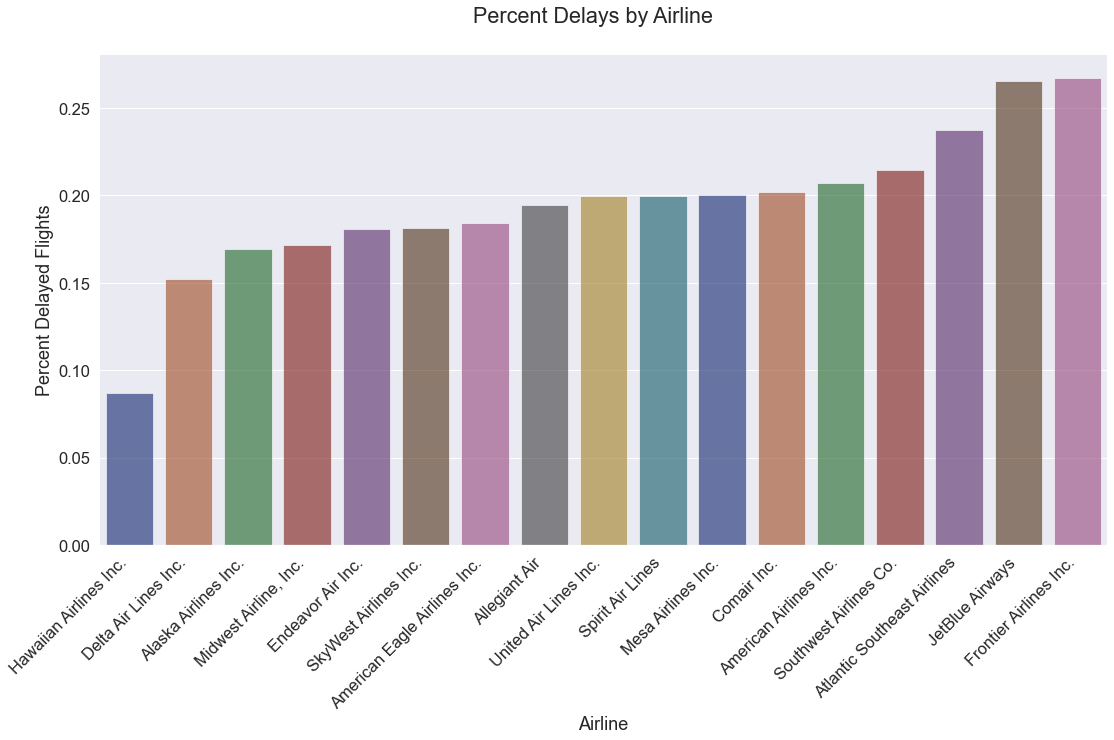

In [12]:
# visualize delay by airline

plot_order = final.groupby('CARRIER_NAME')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="CARRIER_NAME", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2, order=plot_order
)
g.despine(left=True)
g.set_xticklabels(rotation=45, horizontalalignment='right')
g.set_axis_labels("Airline", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Airline", y = 1.05);


In [13]:
# df delay by airline

final.groupby('CARRIER_NAME').mean().sort_values('DEP_DEL15', ascending=False)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
CARRIER_NAME,,,,,,,,,,,,,,,,,,,,,
Frontier Airlines Inc.,0.267296,4.696452,2.894165,22.939541,191.332340,12535.359503,11296.124037,765.467519,1.620501e+06,1857122.0,...,-93.662722,0.097219,0.048170,0.120909,73.582532,8.103593,0.267296,0.198600,0.194515,0.190909
JetBlue Airways,0.265521,4.962780,2.789627,19.203615,138.788612,10006.293553,24650.864743,1897.964693,1.339327e+06,3190369.0,...,-82.911966,0.130774,0.040023,0.052217,70.596307,9.049187,0.265521,0.200760,0.194109,0.194638
Atlantic Southeast Airlines,0.237402,2.454152,2.907511,29.700698,115.546165,11852.455465,10787.406199,1353.265035,1.383400e+06,473794.0,...,-87.251842,0.100707,0.035801,0.110600,72.068417,9.000019,0.237402,0.196619,0.193399,0.199332
Southwest Airlines Co.,0.214405,3.461235,3.456414,18.156123,150.905603,8921.888063,111808.550175,3281.936217,1.143937e+06,13382999.0,...,-98.484728,0.094142,0.029158,0.085968,72.937297,7.951416,0.214405,0.196605,0.194752,0.195116
American Airlines Inc.,0.207231,4.449116,2.588497,32.709310,160.409083,14913.800513,77696.554978,4668.016461,1.805684e+06,11744595.0,...,-91.989765,0.111047,0.022615,0.054581,73.375360,8.250585,0.207231,0.198681,0.194492,0.190291
Comair Inc.,0.201987,2.122452,3.883786,29.467212,76.311704,11846.837249,23735.057090,3870.258015,1.217146e+06,1245396.0,...,-80.666209,0.146309,0.020979,0.067166,71.378261,7.014462,0.201987,0.190066,0.194650,0.199613
Mesa Airlines Inc.,0.200066,2.820889,3.194035,32.862413,75.314221,12487.212391,18550.605282,1732.196144,1.458973e+06,1191889.0,...,-93.725165,0.081984,0.014618,0.049040,76.927391,8.393642,0.200066,0.187587,0.194277,0.198684
Spirit Air Lines,0.199981,4.449923,2.938594,24.975384,182.989591,13054.880368,17091.064421,834.136929,1.692218e+06,2688839.0,...,-90.064260,0.113876,0.023331,0.059354,75.300076,8.182251,0.199981,0.201395,0.194515,0.196905
United Air Lines Inc.,0.199666,5.240472,2.392828,31.288099,158.558322,14159.913615,52363.919214,3325.445157,1.795609e+06,8501631.0,...,-97.114608,0.093460,0.044738,0.105619,70.764656,8.803122,0.199666,0.201886,0.194799,0.192773


In [14]:
# highest delay by grouping of airport and carrier, with a combined count over 50

highest = final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=False)
highest.loc[highest['count'] > 50].head(30)

,,count,mean,std,min,25%,50%,75%,max
DEPARTING_AIRPORT,CARRIER_NAME,,,,,,,,
Newark Liberty International,Frontier Airlines Inc.,237.0,0.493671,0.501018,0.0,0.0,0.0,1.0,1.0
General Mitchell Field,Atlantic Southeast Airlines,235.0,0.476596,0.500518,0.0,0.0,0.0,1.0,1.0
Charleston International,Atlantic Southeast Airlines,203.0,0.448276,0.498547,0.0,0.0,0.0,1.0,1.0
Portland International Jetport,Atlantic Southeast Airlines,88.0,0.443182,0.499608,0.0,0.0,0.0,1.0,1.0
Albany International,JetBlue Airways,249.0,0.421687,0.494824,0.0,0.0,0.0,1.0,1.0
Syracuse Hancock International,Atlantic Southeast Airlines,230.0,0.417391,0.494204,0.0,0.0,0.0,1.0,1.0
Myrtle Beach International,United Air Lines Inc.,193.0,0.414508,0.493918,0.0,0.0,0.0,1.0,1.0
Pensacola Regional,Frontier Airlines Inc.,87.0,0.413793,0.495367,0.0,0.0,0.0,1.0,1.0
Houston Intercontinental,JetBlue Airways,94.0,0.404255,0.493379,0.0,0.0,0.0,1.0,1.0


In [15]:
# df of lowest delay by grouping of airport and carrier, with a combined count over 50

lowest = final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=True)
lowest.loc[lowest['count'] > 50].head(30)

,,count,mean,std,min,25%,50%,75%,max
DEPARTING_AIRPORT,CARRIER_NAME,,,,,,,,
William P Hobby,"Midwest Airline, Inc.",59.0,0.016949,0.130189,0.0,0.0,0.0,0.0,1.0
Lihue Airport,Southwest Airlines Co.,135.0,0.029630,0.170195,0.0,0.0,0.0,0.0,1.0
Keahole,Hawaiian Airlines Inc.,5666.0,0.046770,0.211165,0.0,0.0,0.0,0.0,1.0
Boise Air Terminal,Delta Air Lines Inc.,972.0,0.051440,0.221008,0.0,0.0,0.0,0.0,1.0
Tampa International,Endeavor Air Inc.,171.0,0.058480,0.235337,0.0,0.0,0.0,0.0,1.0
Rochester Monroe County,Delta Air Lines Inc.,924.0,0.062771,0.242681,0.0,0.0,0.0,0.0,1.0
Lihue Airport,Hawaiian Airlines Inc.,5419.0,0.064034,0.244836,0.0,0.0,0.0,0.0,1.0
Truax Field,Delta Air Lines Inc.,1447.0,0.071182,0.257217,0.0,0.0,0.0,0.0,1.0
Eppley Airfield,Alaska Airlines Inc.,265.0,0.071698,0.258476,0.0,0.0,0.0,0.0,1.0


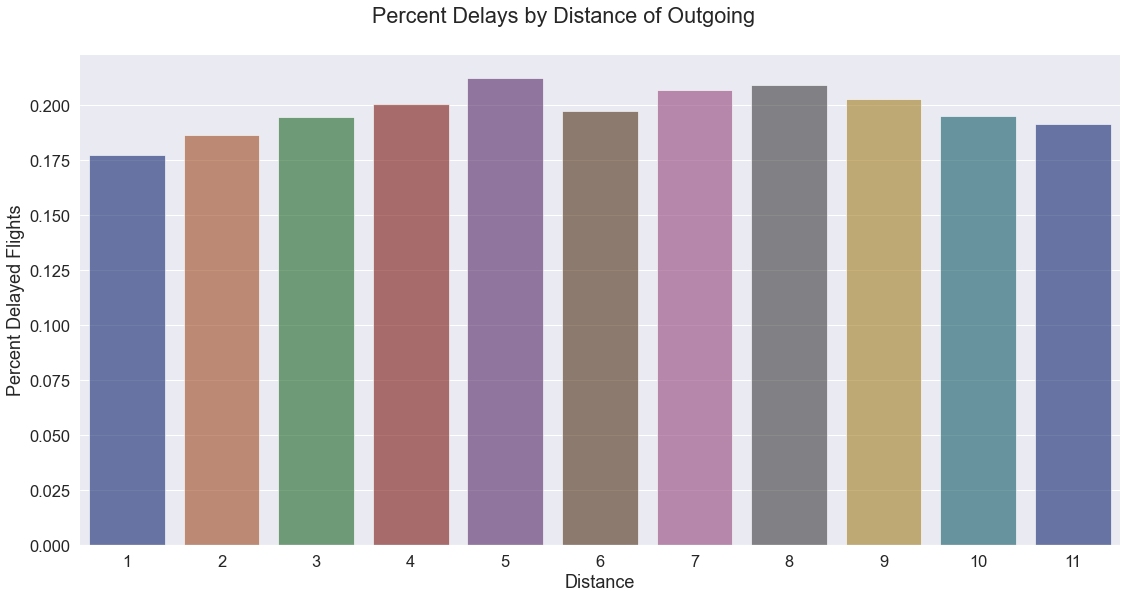

In [16]:
# delays by distance of outgoing flight

g = sns.catplot(
    data=final, kind="bar",
    x="DISTANCE_GROUP", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)

g.set_axis_labels("Distance", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Distance of Outgoing", y = 1.05);


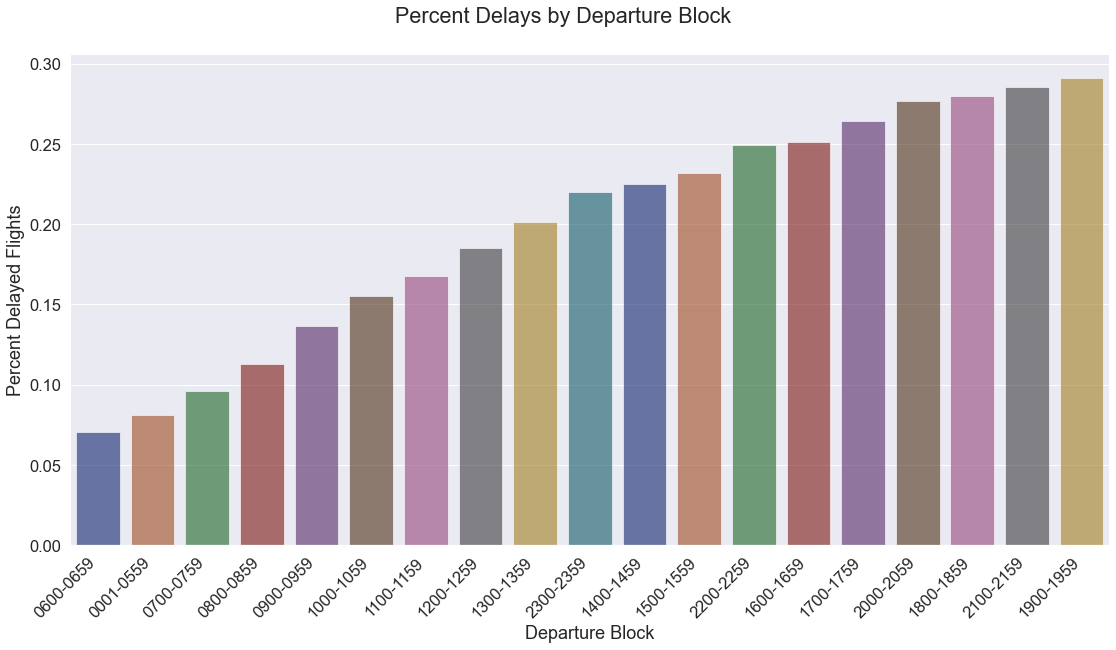

In [17]:
# delay by departure time

plot_order = final.groupby('DEP_TIME_BLK')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

g = sns.catplot(
    data=final, kind="bar",
    x="DEP_TIME_BLK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2,
    order=plot_order
)
g.despine(left=True)

g.set_axis_labels("Departure Block", "Percent Delayed Flights")
g.set_xticklabels(rotation=45, horizontalalignment='right')
g.fig.suptitle("Percent Delays by Departure Block", y = 1.05);


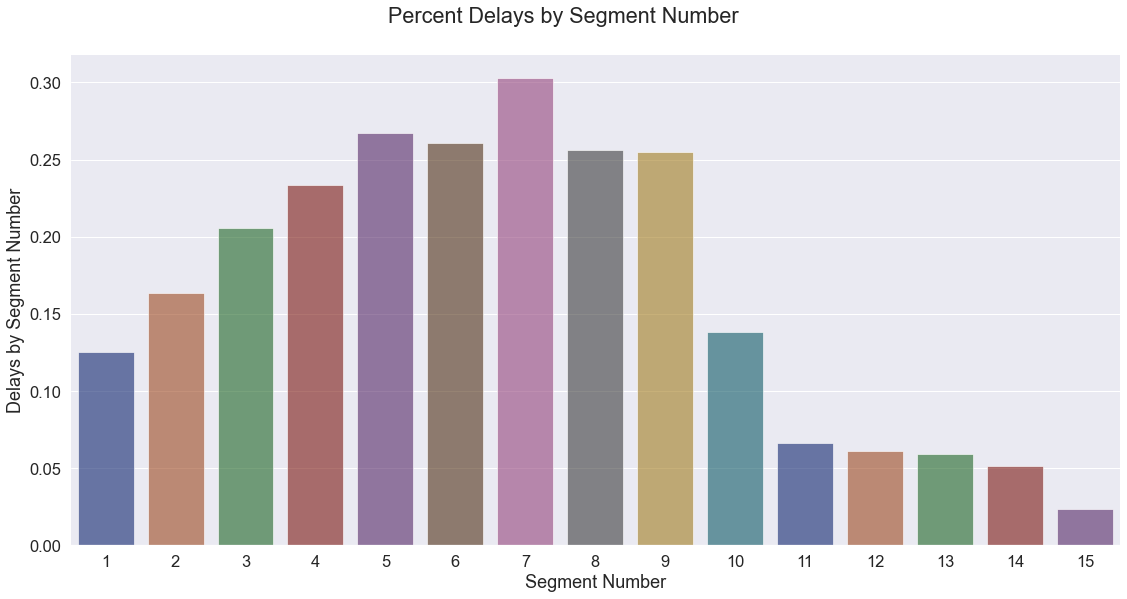

In [18]:
# delay by segment number

g = sns.catplot(
    data=final, kind="bar",
    x="SEGMENT_NUMBER", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Segment Number", "Delays by Segment Number")
g.fig.suptitle("Percent Delays by Segment Number", y = 1.05);


''

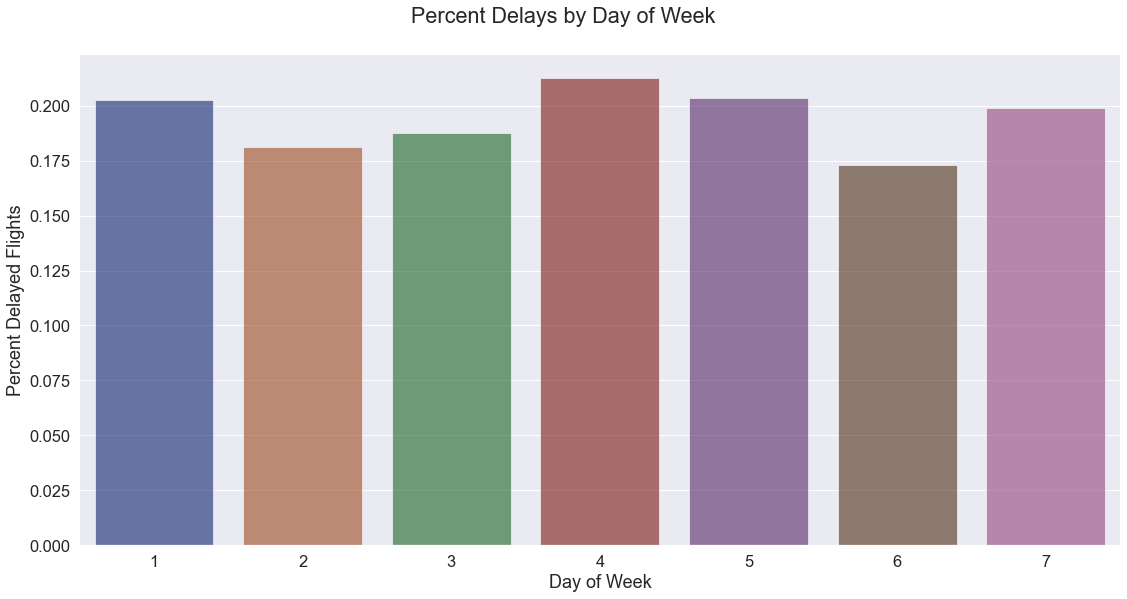

In [19]:
# delay by day of week

g = sns.catplot(
    data=final, kind="bar",
    x="DAY_OF_WEEK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)

g.set_axis_labels("Day of Week", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Day of Week", y = 1.05)
;


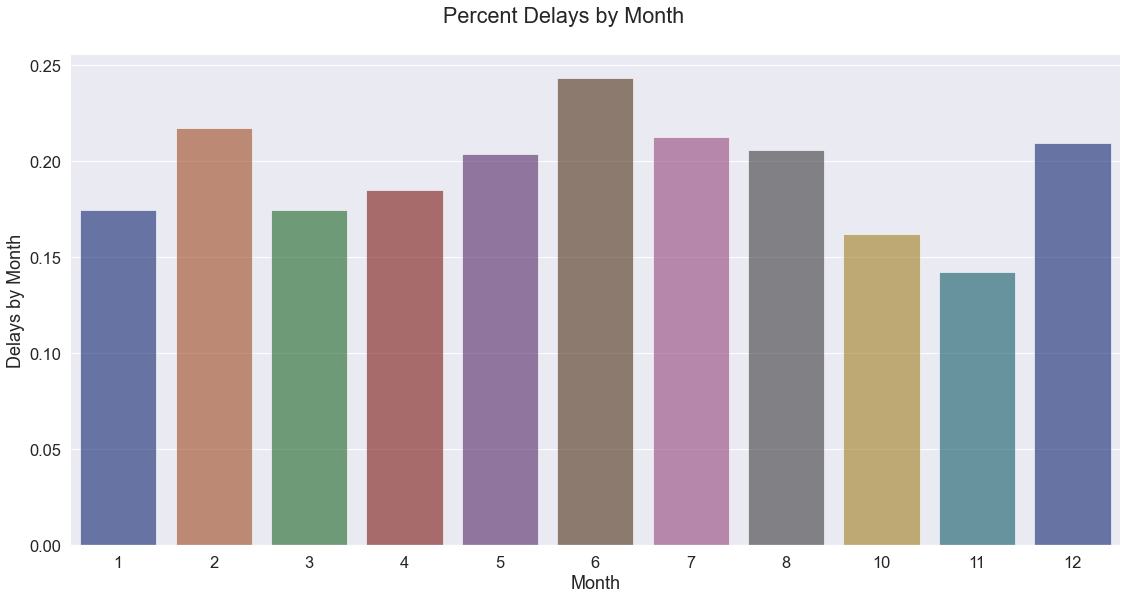

In [20]:
# delay by month

g = sns.catplot(
    data=final, kind="bar",
    x="MONTH", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Delays by Month")

g.fig.suptitle("Percent Delays by Month", y = 1.05);


In [21]:
# Drop categoricals that we were using for our visualizations 

final.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

## Correlations

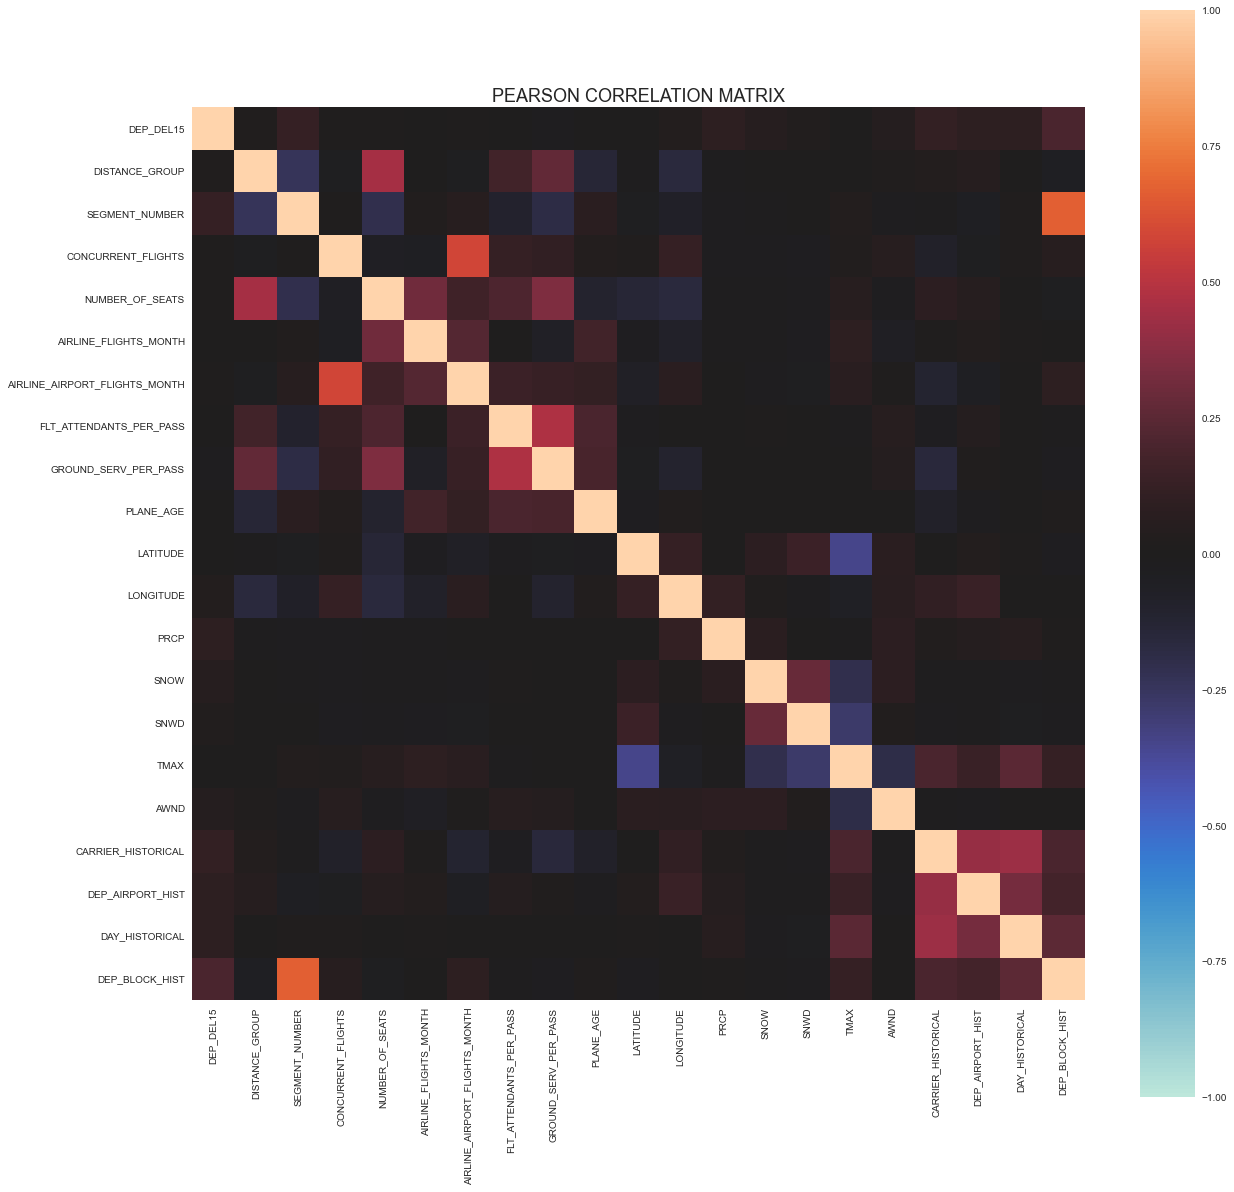

In [47]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [48]:
final.corr()

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEP_DEL15,1.000000,0.015953,0.119982,0.008706,0.012773,0.001382,0.014120,-0.003070,-0.017159,0.005037,...,0.032165,0.086416,0.048051,0.024111,0.003216,0.044763,0.115107,0.093441,0.089561,0.198474
DISTANCE_GROUP,0.015953,1.000000,-0.237705,-0.034587,0.448600,-0.002992,-0.034250,0.167438,0.267528,-0.138387,...,-0.160583,-0.014216,-0.001021,-0.007733,0.004710,0.021918,0.036199,0.047932,0.002181,-0.039120
SEGMENT_NUMBER,0.119982,-0.237705,1.000000,0.013189,-0.203532,0.027518,0.056048,-0.097597,-0.182829,0.075892,...,-0.072276,-0.019189,-0.014744,-0.007251,0.031384,-0.023232,-0.013318,-0.046520,0.020816,0.669615
CONCURRENT_FLIGHTS,0.008706,-0.034587,0.013189,1.000000,-0.053233,-0.040403,0.584052,0.122299,0.102870,0.036498,...,0.117896,-0.020370,-0.017700,-0.027285,0.025770,0.061221,-0.080179,-0.037416,0.021186,0.057637
NUMBER_OF_SEATS,0.012773,0.448600,-0.203532,-0.053233,1.000000,0.306448,0.160401,0.203749,0.344251,-0.102507,...,-0.162859,-0.015120,-0.008757,-0.015691,0.059685,-0.020030,0.081882,0.054114,-0.003668,-0.036392
AIRLINE_FLIGHTS_MONTH,0.001382,-0.002992,0.027518,-0.040403,0.306448,1.000000,0.231677,0.003675,-0.066831,0.171783,...,-0.079112,-0.012225,-0.013773,-0.025763,0.086987,-0.050439,0.012005,0.034978,0.010215,0.000364
AIRLINE_AIRPORT_FLIGHTS_MONTH,0.014120,-0.034250,0.056048,0.584052,0.160401,0.231677,1.000000,0.143029,0.131502,0.117093,...,0.071248,-0.002873,-0.020124,-0.033055,0.068850,0.008679,-0.114397,-0.040327,0.004880,0.092507
FLT_ATTENDANTS_PER_PASS,-0.003070,0.167438,-0.097597,0.122299,0.203749,0.003675,0.143029,1.000000,0.476426,0.199149,...,0.003950,0.000837,0.008218,-0.000817,-0.012980,0.056016,-0.026667,0.039963,0.001228,-0.010117
GROUND_SERV_PER_PASS,-0.017159,0.267528,-0.182829,0.102870,0.344251,-0.066831,0.131502,0.476426,1.000000,0.194878,...,-0.102342,-0.007409,-0.000316,-0.001343,-0.002961,0.042047,-0.149071,0.016701,-0.001676,-0.023726
PLANE_AGE,0.005037,-0.138387,0.075892,0.036498,-0.102507,0.171783,0.117093,0.199149,0.194878,1.000000,...,0.024731,0.005655,-0.000862,0.002029,0.005543,-0.001520,-0.079537,-0.018758,0.006568,0.015722


In [49]:
#Get our list of highly correlated feature pairs:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 95% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,


In [50]:
# drop highly correlated features
final.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

KeyError: "['AVG_MONTHLY_PASS_AIRLINE' 'AIRPORT_FLIGHTS_MONTH'\n 'AVG_MONTHLY_PASS_AIRPORT'] not found in axis"

In [51]:
# Check out our variables correlationg with delay
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)

,level_0,level_1,0
0,DEP_DEL15,DEP_DEL15,1.000000
20,DEP_DEL15,DEP_BLOCK_HIST,0.198474
2,DEP_DEL15,SEGMENT_NUMBER,0.119982
17,DEP_DEL15,CARRIER_HISTORICAL,0.115107
18,DEP_DEL15,DEP_AIRPORT_HIST,0.093441
19,DEP_DEL15,DAY_HISTORICAL,0.089561
12,DEP_DEL15,PRCP,0.086416
13,DEP_DEL15,SNOW,0.048051
16,DEP_DEL15,AWND,0.044763
11,DEP_DEL15,LONGITUDE,0.032165


In [82]:
visual_correl = df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)
visual_correl.drop('level_0', inplace=True, axis=1)
visual_correl.drop(0, inplace=True, axis=0)
visual_correl.reset_index(inplace=True, drop=True)
items = list(visual_correl['level_1'].unique())
replacements = ['Departure Block', 'Segment Number', 'Carrier Delay', 'Airport Delay', 'Day Delay', 'Precipitation',
                   'Snowfall', 'Wind Speed', 'Longitude', 'Ground Snow', 'Customer Service per Pass', 'Flight Distance',
                   'Flights/Month for Airline and Airport', 'Number of Seats', 'Concurrent Outgoing', 'Plane Age',
               'Max Temp', 'Flight Attendants per Pass', 'Airline Flights per Month', 'Latitude']
visual_correl['level_1'].replace(items, replacements, inplace=True)


visual_correl

,level_1,0
0,Departure Block,0.198474
1,Segment Number,0.119982
2,Carrier Delay,0.115107
3,Airport Delay,0.093441
4,Day Delay,0.089561
5,Precipitation,0.086416
6,Snowfall,0.048051
7,Wind Speed,0.044763
8,Longitude,0.032165
9,Ground Snow,0.024111


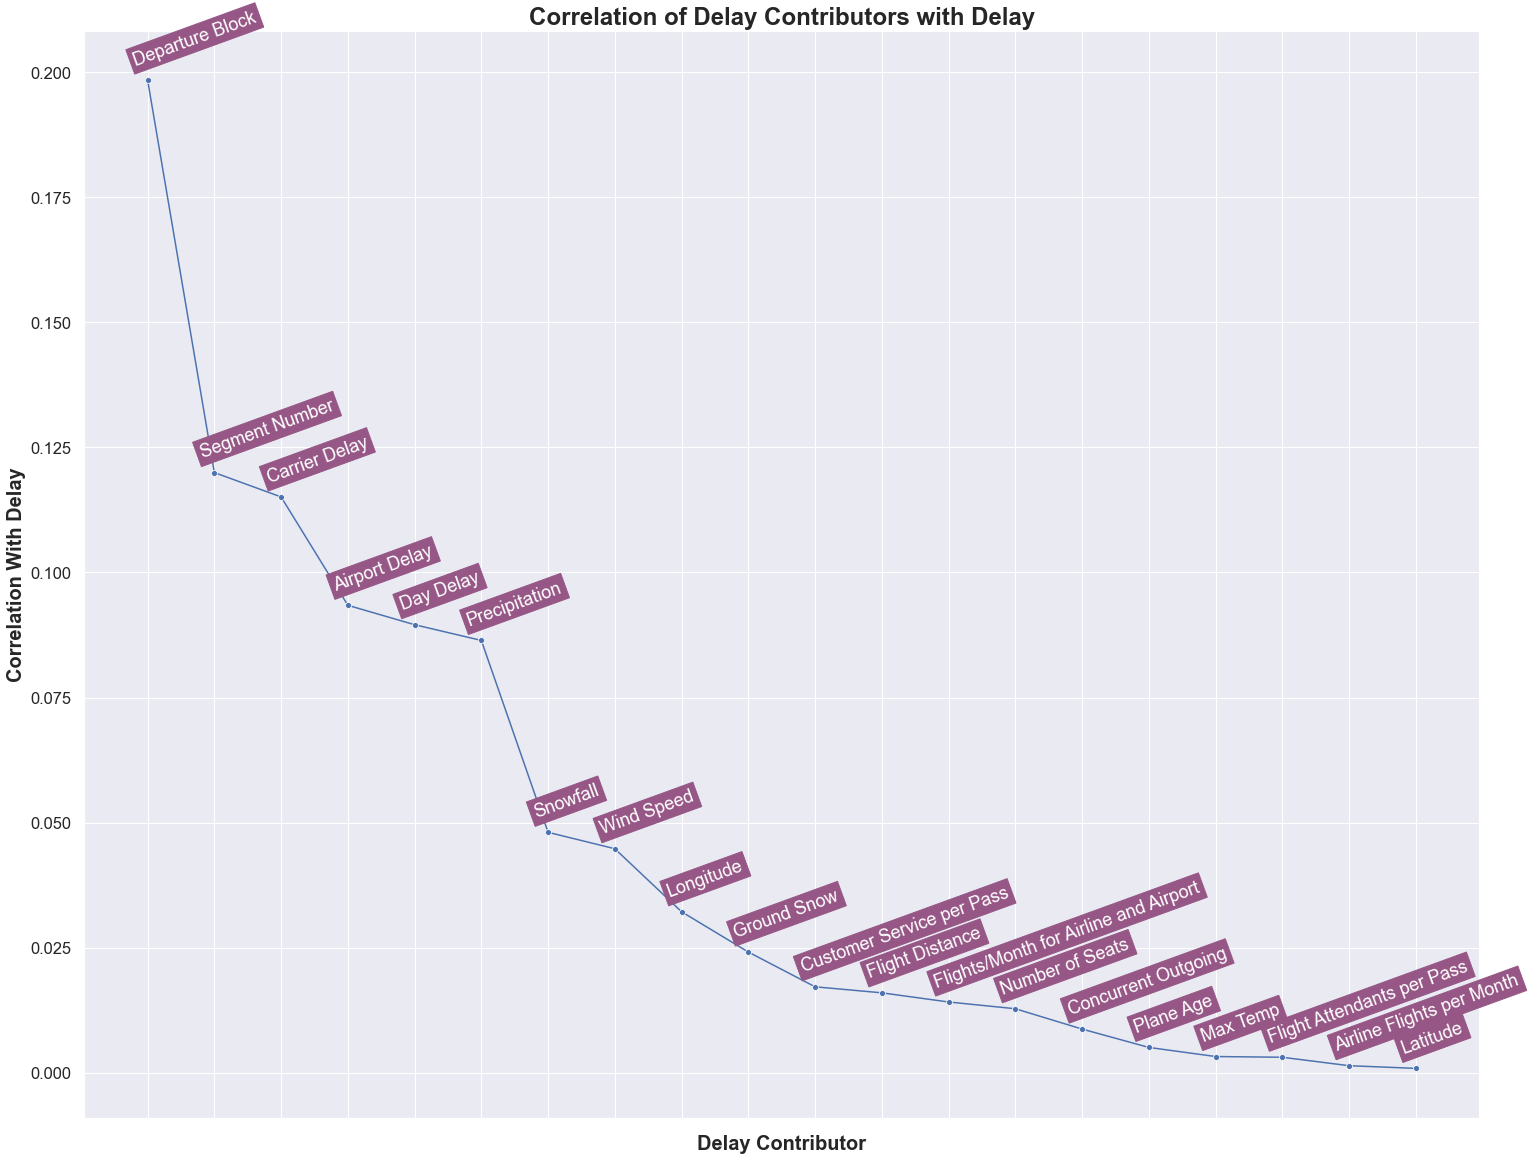

In [99]:
# prepare our figure size and scale
sns.set(rc={'figure.figsize':(25,10)}, font_scale = 1.5)

# set our lineplot
scatter5 = sns.lineplot(x=visual_correl['level_1'], y=visual_correl[0], data=visual_correl, marker='o', palette='bright')

# label points on the plot
for x, y, z in zip(np.arange(0, 20, step=1), visual_correl['level_1'], visual_correl[0]):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x-.25, # x-coordinate position of data label
        y = z+.003, # y-coordinate position of data label
        s = '{}'.format(y), # data label
        rotation = 20,
        color = 'white').set_backgroundcolor('#965786') # set colour of line

# hide the x ticks 
scatter5.axes.xaxis.set_ticklabels([])

# label our figure

scatter5.set_ylabel('Correlation With Delay',weight='bold',fontsize=20)
scatter5.set_xlabel('Delay Contributor', weight='bold',fontsize=20)
scatter5.set_title('Correlation of Delay Contributors with Delay',weight='bold',fontsize=24);

#plt.savefig('images/delay_contributors.png')

# Modeling

In [28]:
# prepare dictionary to store testing results

randomstate=42

spot_check = {}
spot_check['Model'] = []
spot_check['f1'] = []
spot_check['accuracy'] = []
spot_check['auc'] = []
spot_check['time'] = []

models = {}
models['Model'] = []
models['f1'] = []
models['accuracy'] = []
models['auc'] = []
models['time'] = []

## PreProcessing

In [29]:
print('Raw counts: \n')
print(final['DEP_DEL15'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DEP_DEL15'].value_counts(normalize=True))

Raw counts: 

0    3685343
1     891761
Name: DEP_DEL15, dtype: int64
-----------------------------------
Normalized counts: 

0    0.805169
1    0.194831
Name: DEP_DEL15, dtype: float64


In [30]:
# Make x-train and y-train
x_train = final.drop('DEP_DEL15', axis=1)
y_train = final['DEP_DEL15']

In [31]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test.pkl')

x_val = val.drop('DEP_DEL15', axis=1)
y_val = val['DEP_DEL15']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

### Processing Pipelines

In [32]:
# set up processing categories

features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

poly_features = ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST']

features_cat, cont_features, poly_features

([],
 ['DISTANCE_GROUP',
  'SEGMENT_NUMBER',
  'CONCURRENT_FLIGHTS',
  'NUMBER_OF_SEATS',
  'AIRLINE_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'FLT_ATTENDANTS_PER_PASS',
  'GROUND_SERV_PER_PASS',
  'PLANE_AGE',
  'LATITUDE',
  'LONGITUDE',
  'PRCP',
  'SNOW',
  'SNWD',
  'TMAX',
  'AWND',
  'CARRIER_HISTORICAL',
  'DEP_AIRPORT_HIST',
  'DAY_HISTORICAL',
  'DEP_BLOCK_HIST'],
 ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST'])

In [33]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


Using the framework proposed at https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

Model Plans:

Linear Algorithms: 
* Logistic Regression
* Naive Bayes

Nonlinear Algorithms: 
* Decision Trees
* SVM
* KNN

Ensemble Algorithms: 
* Extra Trees
* Random Forest
* XGBoost
* CatBoost
* AdaBoost
* Gradient Boosted Trees

Feature Selection Plans:

* Basic Correlation
* RFECV
* Permutation Importance

### Determine required data to train model

The Learning Curve will tell us if we can use less than our full dataset of millions of rows to train our model.

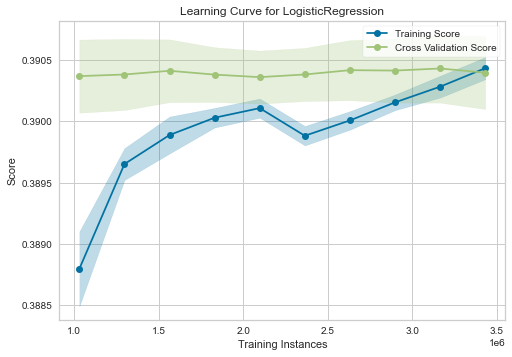

In [34]:
from yellowbrick.model_selection import LearningCurve

cv = StratifiedKFold(n_splits=4)
sizes = np.linspace(0.3, 1.0, 10)

model = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(processed_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

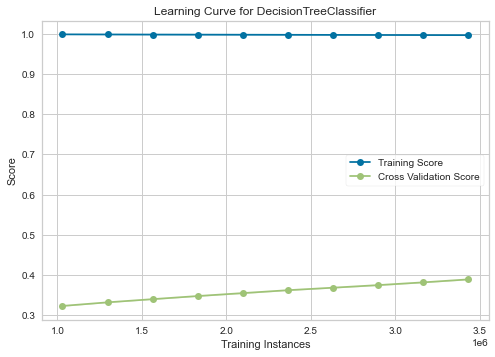

In [35]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=randomstate)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(processed_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

## Spot Check Baseline Algorithms

We will run the basic algorithms with no hyperparameter tuning, to get a feel for their baseline performance.

For computational cost reasons, we are going to spot check all of our algorithms on a MUCH smaller train set. Once we have a firm idea of what might work, we'll select the top algorithms and train those on our larger data set.

In [36]:
# Make smaller sets to spot check different algorithms
# Looking to get two sets of about 500k records

x_break, x_discard, y_break, y_discard = train_test_split(processed_train, y_train, test_size=.8, random_state=randomstate, stratify=y_train)
x_sample, x_rest, y_sample, y_rest = train_test_split(x_break, y_break, test_size=.5, random_state=randomstate, stratify=y_break)

In [40]:
# Set up baseline models
baseline_models = {
    "Logistic Regression": LogisticRegression(random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1),
    "Perceptron": Perceptron(n_jobs=-1),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Trees" : ExtraTreesClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(verbosity=0, n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=False, task_type='GPU', devices='0:1'),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check_classifier(this_model, x_sample, y_sample, label, x_rest, y_rest)



Running Logistic Regression Classification
CV 3 Accuracy Train Score: 59.09
CV 3 F1 Train Score: 39.11
CV 3 Auc Train Score: 67.03

Testing Accuracy:  0.5910795044897424
Testing f1 Score:  0.3912219016610993
Testing AUC Score:  0.6226577642024713 

              precision    recall  f1-score   support

           0       0.88      0.57      0.69    368534
           1       0.28      0.67      0.39     89176

    accuracy                           0.59    457710
   macro avg       0.58      0.62      0.54    457710
weighted avg       0.76      0.59      0.63    457710

Elapsed Time: 32.687649726867676


Running Perceptron Classification
CV 3 Accuracy Train Score: 68.99
CV 3 F1 Train Score: 25.94
CV 3 Auc Train Score: 55.86

Testing Accuracy:  0.7028839221341023
Testing f1 Score:  0.1583497855538158
Testing AUC Score:  0.49085444861634636 

              precision    recall  f1-score   support

           0       0.80      0.84      0.82    368534
           1       0.18      0.14    

## Spot-Check Imbalanced Algorithms

Spot check the same baseline algorithms, but after using various balancing methods, both on the data directly and with class_weight

### Cost-Balanced class weights

In [37]:
# get balance ratio of y for algorithms that require an input ratio
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]

In [43]:
# set up weighted/balanced models
weighted_models = {
    "Logistic Regression_Weighted": LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1),
    "Perceptron": Perceptron(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": xgb.XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}

# spot check weighted models
for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check_classifier(this_model, x_sample, y_sample, label, x_rest, y_rest)



Running Logistic Regression_Weighted Classification
CV 3 Accuracy Train Score: 56.39
CV 3 F1 Train Score: 38.94
CV 3 Auc Train Score: 67.22

Testing Accuracy:  0.5651766402307138
Testing f1 Score:  0.39028365383142527
Testing AUC Score:  0.6216944891213891 

              precision    recall  f1-score   support

           0       0.88      0.53      0.66    368534
           1       0.27      0.71      0.39     89176

    accuracy                           0.57    457710
   macro avg       0.58      0.62      0.53    457710
weighted avg       0.76      0.57      0.61    457710

Elapsed Time: 35.43765592575073


Running Perceptron Classification
CV 3 Accuracy Train Score: 56.8
CV 3 F1 Train Score: 31.27
CV 3 Auc Train Score: 57.08

Testing Accuracy:  0.5507373664547421
Testing f1 Score:  0.3130716552530483
Testing AUC Score:  0.541159389113181 

              precision    recall  f1-score   support

           0       0.83      0.56      0.67    368534
           1       0.22      0.

In [44]:
# Check model scores chart so far

chart = pd.DataFrame(spot_check)
chart.sort_values('f1', ascending=False)

,Model,f1,accuracy,auc,time
16,XGBoost_Weighted,0.427078,0.670669,0.655264,33.208131
15,Balanced Random Forest,0.423348,0.658653,0.652766,31.176254
17,CatBoost_Weighted,0.422260,0.657211,0.651811,51.936637
0,Logistic Regression,0.391222,0.591080,0.622658,32.687650
10,Logistic Regression_Weighted,0.390284,0.565177,0.621694,35.437656
11,Perceptron,0.313072,0.550737,0.541159,3.814461
3,Decision Tree,0.312871,0.721433,0.571374,25.359514
2,Naive Bayes,0.311144,0.749879,0.575553,3.239939
12,Decision Tree Classifier_Weighted,0.299701,0.728501,0.565406,24.847537
5,Random Forest,0.233138,0.812276,0.559925,51.587320


## Further Check Top Algorithms

### Resample to minority class

The 6.5 million row combined dataset is a lot of data for a system to handle. We will reduce this to a more manageable data set by undersampling the majority class to match the minority class.

In doing so we will turn this into a balanced classification problem, with an equal ratio for the target.

TomekLinks - closest pairs of opposite classification neighbors. The majority class of these pairs is removed. TomekLinks gets rid of noisy/ambiguous data.

RandomUnderSampler - Picks majority samples to use entirely at random


In [38]:
# define balanced models to check resampling

xgb = xgb.XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1)
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1')
bal_forest = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1)
log_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1)
bayes = GaussianNB()

##### Method 1 - TomekLinks 

These look for differently classified pairs of data where the data is very similar but the labels are different. It elminates the majority instance in these pairs. This helps the dataset remove noisy or ambiguous data.

In [48]:

tl = TomekLinks(sampling_strategy='majority', n_jobs=-1)
x_tl, y_tl = tl.fit_resample(x_sample, y_sample)



Running XGBoost_Weighted_TomekLinks Classification
CV 3 Accuracy Train Score: 65.89
CV 3 F1 Train Score: 44.77
CV 3 Auc Train Score: 72.26

Testing Accuracy:  0.6447117170260646
Testing f1 Score:  0.423518818528904
Testing AUC Score:  0.6542413807756853 

              precision    recall  f1-score   support

           0       0.89      0.64      0.74    368534
           1       0.31      0.67      0.42     89176

    accuracy                           0.64    457710
   macro avg       0.60      0.65      0.58    457710
weighted avg       0.78      0.64      0.68    457710

Elapsed Time: 31.346441745758057


In [70]:
# spot check our TomekLinks with various balanced models

spot_check_classifier(xgb, x_tl, y_tl, "XGBoost_Weighted_TomekLinks", x_rest, y_rest)
spot_check_classifier(catboost, x_tl, y_tl, "CatBoost_Weighted_TomekLinks", x_rest, y_rest)
spot_check_classifier(bal_forest, x_tl, y_tl, "Balanced_Forest_TomekLinks", x_rest, y_rest)
spot_check_classifier(log_weighted, x_tl, y_tl, "LogReg_Weighted_TomekLinks", x_rest, y_rest)
spot_check_classifier(bayes, x_tl, y_tl, "Bayes_TomekLinks", x_rest, y_rest)




Running CatBoost_Weighted_TomekLinks Classification
CV 3 Accuracy Train Score: 66.55
CV 3 F1 Train Score: 44.6
CV 3 Auc Train Score: 72.03

Testing Accuracy:  0.653525157851041
Testing f1 Score:  0.4217270337187636
Testing AUC Score:  0.6516051065191197 

              precision    recall  f1-score   support

           0       0.89      0.65      0.75    368534
           1       0.31      0.65      0.42     89176

    accuracy                           0.65    457710
   macro avg       0.60      0.65      0.59    457710
weighted avg       0.77      0.65      0.69    457710

Elapsed Time: 49.61102104187012


Running Balanced_Forest_TomekLinks Classification
CV 3 Accuracy Train Score: 67.17
CV 3 F1 Train Score: 45.42
CV 3 Auc Train Score: 72.95

Testing Accuracy:  0.6536016254833846
Testing f1 Score:  0.42350066540131337
Testing AUC Score:  0.6533909085559194 

              precision    recall  f1-score   support

           0       0.89      0.65      0.75    368534
           1   

##### Method 2 - Random Under Sampler

This makes the majority samples equal to the minority samples by randomly removing samples.

This is a risky method because it removes a lot of real data, but it might work on a data set with as many samples as ours.

In [18]:
# Set up RandomUnderSampler

rus = RandomUnderSampler(random_state=randomstate, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(x_sample, y_sample)

In [71]:
# spot check RUS with different classifiers

spot_check_classifier(xgb, x_rus, y_rus, "XGBoost_Weighted_RandomUnderSampler", x_rest, y_rest)
spot_check_classifier(catboost, x_rus, y_rus, "CatBoost_Weighted_RUS", x_rest, y_rest)
spot_check_classifier(bal_forest, x_rus, y_rus, "Balanced_Forest_RUS", x_rest, y_rest)
spot_check_classifier(log_weighted, x_rus, y_rus, "LogReg_Weighted_RUS", x_rest, y_rest)
spot_check_classifier(bayes, x_rus, y_rus, "Bayes_RUS", x_rest, y_rest)



Running CatBoost_Weighted_RUS Classification
CV 3 Accuracy Train Score: 65.16
CV 3 F1 Train Score: 65.0
CV 3 Auc Train Score: 71.03

Testing Accuracy:  0.6526272093683774
Testing f1 Score:  0.42114652278701303
Testing AUC Score:  0.6510984937074615 

              precision    recall  f1-score   support

           0       0.88      0.65      0.75    368534
           1       0.31      0.65      0.42     89176

    accuracy                           0.65    457710
   macro avg       0.60      0.65      0.59    457710
weighted avg       0.77      0.65      0.69    457710

Elapsed Time: 37.76225566864014


Running Balanced_Forest_RUS Classification
CV 3 Accuracy Train Score: 66.67
CV 3 F1 Train Score: 66.38
CV 3 Auc Train Score: 73.77

Testing Accuracy:  0.6253501125166591
Testing f1 Score:  0.41179961239645324
Testing AUC Score:  0.6434591143244579 

              precision    recall  f1-score   support

           0       0.89      0.61      0.73    368534
           1       0.30    

### Data Oversampling

SMOTE creates synthetic data from the minority class, adding minor variations so that it is not simply duplicates of minority data.

In [51]:
# Set up SMOTE

smote = SMOTE(n_jobs=-1)
processed_train_resampled, y_train_resampled = smote.fit_resample(x_sample, y_sample) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    368534
0    368534
Name: DEP_DEL15, dtype: int64


Running XGBoost_Weighted_SMOTE Classification
CV 3 Accuracy Train Score: 68.02
CV 3 F1 Train Score: 66.05
CV 3 Auc Train Score: 91.18

Testing Accuracy:  0.6125647243888052
Testing f1 Score:  0.41192641991848755
Testing AUC Score:  0.6443641372025497 

              precision    recall  f1-score   support

           0       0.89      0.59      0.71    368534
           1       0.29      0.70      0.41     89176

    accuracy                           0.61    457710
   macro avg       0.59      0.64      0.56    457710
weighted avg       0.77      0.61      0.65    457710

Elapsed Time: 62.7189154624939


In [74]:
# Spot check SMOTE with different classifiers

spot_check_classifier(xgb, processed_train_resampled, y_train_resampled, "XGBoost_Weighted_SMOTE", x_rest, y_rest)
spot_check_classifier(catboost, processed_train_resampled, y_train_resampled, "CatBoost_Weighted_SMOTE", x_rest, y_rest)
spot_check_classifier(bal_forest, processed_train_resampled, y_train_resampled, "Balanced_Forest_SMOTE", x_rest, y_rest)
spot_check_classifier(log_weighted, processed_train_resampled, y_train_resampled, "LogReg_Weighted_SMOTE", x_rest, y_rest)
spot_check_classifier(bayes, processed_train_resampled, y_train_resampled, "Bayes_SMOTE", x_rest, y_rest)



Running CatBoost_Weighted_SMOTE Classification
CV 3 Accuracy Train Score: 85.78
CV 3 F1 Train Score: 78.78
CV 3 Auc Train Score: 91.05

Testing Accuracy:  0.8105634572108977
Testing f1 Score:  0.1463409831546406
Testing AUC Score:  0.5349369688721722 

              precision    recall  f1-score   support

           0       0.82      0.99      0.89    368534
           1       0.60      0.08      0.15     89176

    accuracy                           0.81    457710
   macro avg       0.71      0.53      0.52    457710
weighted avg       0.77      0.81      0.75    457710

Elapsed Time: 60.37578845024109


Running Balanced_Forest_SMOTE Classification
CV 3 Accuracy Train Score: 86.45
CV 3 F1 Train Score: 83.11
CV 3 Auc Train Score: 95.01

Testing Accuracy:  0.7994385090996482
Testing f1 Score:  0.29816741718208856
Testing AUC Score:  0.5793194803222599 

              precision    recall  f1-score   support

           0       0.83      0.94      0.88    368534
           1       0.47

### Unused Methods

A desire existed to use a few different combination oversampling and undersampling methods. In particular I wanted to try One Sided Selection and Condensed Nearest Neighbor. 

TomekLinks + Condensed Nearest Neighbor = OneSidedSelection
    - One step process. Identifies TomekLinks, which are closest pairs of opposite classification neighbors. The majority class of these pairs is removed. CNN then gets rid of redundant majority class examples that are far from the class boundary. When used together, TomekLinks gets rid of noisy/ambiguous data, and then CNN gets rid of redundant but decisive majority data.

Condensed Nearest Neighbor + Edited Nearest Neighbor = NeighbourhoodCleaning Rule
    - This process does CNN first (rather than second like OneSided). Redundant but decisive majority data is removed. Then ENN removes the noisy/ambiguous examples using a K-Nearest Neighbors algorithm with default of 3 neighbors. This method usually results in less cut data. 

After this removal process, both are used with SMOTE to oversample the minority data.

Unfortunately our data set was too large and the computational cost of these methods was too high.

## Feature Selection

### Permutation Importance

Permutation Importance randomly shuffles the data in a feature, then re-fits and re-scores the model. It turns the feature into noise by shuffling, and then in re-scoring asseses the impact the model. Features of high importance will create more model error when shuffled.

In [21]:
xgb.fit(x_sample, y_sample)

r = permutation_importance(xgb, x_sample, y_sample,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0.001:
        print(f"{x_sample.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")
        
importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0.001:
        importances[x_sample.columns[i]] = r.importances_mean[i]
    else: continue
        
print(importances)

important_features = list(importances.keys())
print(important_features)

DEP_BLOCK_HIST 		Importance: 0.134 
SEGMENT_NUMBER 		Importance: 0.133 
PLANE_AGE 		Importance: 0.016 
NUMBER_OF_SEATS 		Importance: 0.013 
PRCP     		Importance: 0.012 
CONCURRENT_FLIGHTS 		Importance: 0.012 
LONGITUDE 		Importance: 0.011 
DEP_AIRPORT_HIST 		Importance: 0.010 
TMAX     		Importance: 0.010 
LATITUDE 		Importance: 0.008 
AIRLINE_AIRPORT_FLIGHTS_MONTH 		Importance: 0.007 
FLT_ATTENDANTS_PER_PASS 		Importance: 0.006 
CARRIER_HISTORICAL 		Importance: 0.006 
DISTANCE_GROUP 		Importance: 0.005 
AWND     		Importance: 0.005 
DAY_HISTORICAL 		Importance: 0.005 
AIRLINE_FLIGHTS_MONTH 		Importance: 0.004 
{'DEP_BLOCK_HIST': 0.13442718460742978, 'SEGMENT_NUMBER': 0.13340747052354837, 'PLANE_AGE': 0.01636917116369172, 'NUMBER_OF_SEATS': 0.013236183027098666, 'PRCP': 0.01163546059003883, 'CONCURRENT_FLIGHTS': 0.011505684094004216, 'LONGITUDE': 0.011456890461937342, 'DEP_AIRPORT_HIST': 0.010339152156023117, 'TMAX': 0.010045225142557531, 'LATITUDE': 0.008092751596717008, 'AIRLINE_AIR

In [39]:
# re-iterating the important permuted features so that we don't have to run the above block ever time

important_features = ['DEP_BLOCK_HIST', 'SEGMENT_NUMBER', 'PLANE_AGE', 'NUMBER_OF_SEATS', 'PRCP', 
                      'CONCURRENT_FLIGHTS', 'LONGITUDE', 'DEP_AIRPORT_HIST', 'TMAX', 'LATITUDE', 
                      'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'FLT_ATTENDANTS_PER_PASS', 'CARRIER_HISTORICAL', 
                      'DISTANCE_GROUP', 'AWND', 'DAY_HISTORICAL', 'AIRLINE_FLIGHTS_MONTH']

permutation_x_train = x_sample[important_features]
permutation_x_test = x_rest[important_features]

In [72]:
# spot check our models with permutation importance

spot_check_classifier(xgb, permutation_x_train, y_sample, 'XGBoost_Weighted w/Permutation Importance', permutation_x_test, y_rest)
spot_check_classifier(catboost, permutation_x_train, y_sample, "CatBoost_Weighted_w/Permutation Importance", permutation_x_test, y_rest)
spot_check_classifier(bal_forest, permutation_x_train, y_sample, "Balanced_Forest_w/Permutation Importance", permutation_x_test, y_rest)
spot_check_classifier(log_weighted, permutation_x_train, y_sample, "LogReg_Weighted_w/Permutation Importance", permutation_x_test, y_rest)
spot_check_classifier(bayes, permutation_x_train, y_sample, "Bayes_w/Permutation Importance", permutation_x_test, y_rest)



Running CatBoost_Weighted_w/Permutation Importance Classification
CV 3 Accuracy Train Score: 65.48
CV 3 F1 Train Score: 41.92
CV 3 Auc Train Score: 70.78

Testing Accuracy:  0.6566100806187324
Testing f1 Score:  0.42212622019596674
Testing AUC Score:  0.6517314863866537 

              precision    recall  f1-score   support

           0       0.88      0.66      0.76    368534
           1       0.31      0.64      0.42     89176

    accuracy                           0.66    457710
   macro avg       0.60      0.65      0.59    457710
weighted avg       0.77      0.66      0.69    457710

Elapsed Time: 51.13840651512146


Running Balanced_Forest_w/Permutation Importance Classification
CV 3 Accuracy Train Score: 65.49
CV 3 F1 Train Score: 42.03
CV 3 Auc Train Score: 70.7

Testing Accuracy:  0.6599593629153832
Testing f1 Score:  0.42439551173472784
Testing AUC Score:  0.6536880940384167 

              precision    recall  f1-score   support

           0       0.88      0.66      

### PCA

Principal Component Analysis is a dimensional reduction method that looks to find and combine features based on the strength of their mathematical relationships. It seeks to reduce the number of variables into a smaller number of variables that still contain most of the information.

Explained variance with all components is  99.99999999999999
1 component explains  19.467021682366727
1st and 2nd components explains  29.598804363596003
1st to 3rd components explains  38.20707800822865
1st to 4th components explains  45.42202142851846


Text(0, 0.5, 'Explained Variance')

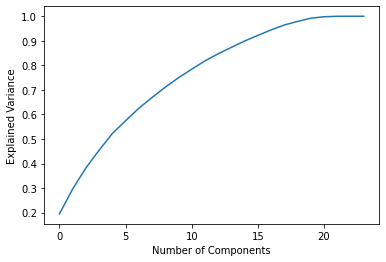

In [57]:
# study the amount of variance explained by each variable

pca_all = PCA(n_components=processed_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(processed_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [58]:
# Get the numerical variance explained by the first two principal components

pca_2 = PCA(n_components=2, random_state=randomstate)
x_pca_2 = pca_2.fit_transform(x_sample)

print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

Explained variation per principal component: [0.1944817  0.10150143]


Text(0, 0.5, 'Second Component')

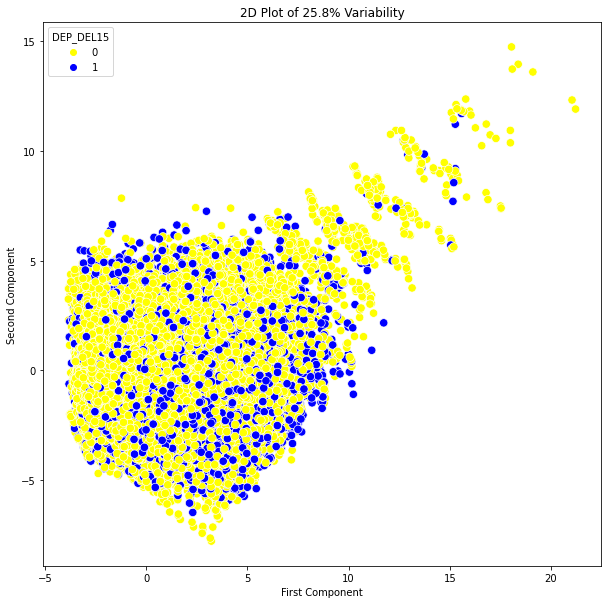

In [59]:
# 2D plot of the first two components

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_pca_2[:,0], y=x_pca_2[:,1], s=70, hue=y_sample, palette=['yellow', 'blue'])
plt.title("2D Plot of 25.8% Variability")
plt.xlabel("First Component")
plt.ylabel("Second Component")

In [60]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(x_sample)
x_pca_95_test = pca_95th.transform(x_rest)

print(x_pca_95.shape[1],"components, starting from all features")

18 components, starting from all features


Running XGBoost_Weighted_PCA Classification
CV 3 Accuracy Train Score: 64.92
CV 3 F1 Train Score: 40.13
CV 3 Auc Train Score: 68.38

Testing Accuracy:  0.6495553953376593
Testing f1 Score:  0.40533707032060984
Testing AUC Score:  0.6357094191795493 

              precision    recall  f1-score   support

           0       0.88      0.66      0.75    368534
           1       0.30      0.61      0.41     89176

    accuracy                           0.65    457710
   macro avg       0.59      0.64      0.58    457710
weighted avg       0.76      0.65      0.68    457710

Elapsed Time: 60.63201332092285


In [75]:
# spot check the models using the 95% principal components

spot_check_classifier(xgb, x_pca_95, y_sample, "XGBoost_Weighted_PCA", x_pca_95_test, y_rest)
spot_check_classifier(catboost, x_pca_95, y_sample, "CatBoost_Weighted_PCA", x_pca_95_test, y_rest)
spot_check_classifier(bal_forest, x_pca_95, y_sample, "Balanced_Forest_PCA", x_pca_95_test, y_rest)
spot_check_classifier(log_weighted, x_pca_95, y_sample, "LogReg_Weighted_PCA", x_pca_95_test, y_rest)
spot_check_classifier(bayes, x_pca_95, y_sample, "Bayes_Weighted_PCA", x_pca_95_test, y_rest)



Running CatBoost_Weighted_PCA Classification
CV 3 Accuracy Train Score: 63.99
CV 3 F1 Train Score: 40.65
CV 3 Auc Train Score: 69.21

Testing Accuracy:  0.6396233422909703
Testing f1 Score:  0.4073185104272964
Testing AUC Score:  0.6380973163477 

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    368534
           1       0.30      0.64      0.41     89176

    accuracy                           0.64    457710
   macro avg       0.59      0.64      0.57    457710
weighted avg       0.77      0.64      0.68    457710

Elapsed Time: 66.00150227546692


Running Balanced_Forest_PCA Classification
CV 3 Accuracy Train Score: 64.06
CV 3 F1 Train Score: 40.61
CV 3 Auc Train Score: 69.05

Testing Accuracy:  0.6464180376220751
Testing f1 Score:  0.411416850328409
Testing AUC Score:  0.6418152178664956 

              precision    recall  f1-score   support

           0       0.88      0.65      0.75    368534
           1       0.30      0.6

In [61]:
# testing the principal components AFTER using permutation importance

pca_95th_perm = PCA(n_components=.95, random_state=randomstate)
x_pca_95_perm = pca_95th_perm.fit_transform(permutation_x_train)
x_pca_perm_test = pca_95th_perm.transform(permutation_x_test)

print(x_pca_95_perm.shape[1],"components, starting from permuted features")

15 components, starting from permuted features


Running XGBoost_Weighted_PCA_Perm Classification
CV 3 Accuracy Train Score: 64.25
CV 3 F1 Train Score: 39.69
CV 3 Auc Train Score: 67.84

Testing Accuracy:  0.6401564309278801
Testing f1 Score:  0.40115911255899184
Testing AUC Score:  0.63199786136629 

              precision    recall  f1-score   support

           0       0.87      0.65      0.74    368534
           1       0.30      0.62      0.40     89176

    accuracy                           0.64    457710
   macro avg       0.59      0.63      0.57    457710
weighted avg       0.76      0.64      0.68    457710

Elapsed Time: 41.08177924156189


In [73]:
# spot check the PCA with permutation importance

spot_check_classifier(xgb, x_pca_95_perm, y_sample, "XGBoost_Weighted_PCA_Perm", x_pca_perm_test, y_rest)
spot_check_classifier(catboost, x_pca_95_perm, y_sample, "CatBoost_Weighted_PCA_Perm", x_pca_perm_test, y_rest)
spot_check_classifier(bal_forest, x_pca_95_perm, y_sample, "Balanced_Forest_PCA_Perm", x_pca_perm_test, y_rest)
spot_check_classifier(log_weighted, x_pca_95_perm, y_sample, "LogReg_Weighted_PCA_Perm", x_pca_perm_test, y_rest)
spot_check_classifier(bayes, x_pca_95_perm, y_sample, "Bayes_Weighted_PCA_Perm", x_pca_perm_test, y_rest)



Running CatBoost_Weighted_PCA_Perm Classification
CV 3 Accuracy Train Score: 63.8
CV 3 F1 Train Score: 40.38
CV 3 Auc Train Score: 68.72

Testing Accuracy:  0.6374123353214918
Testing f1 Score:  0.40446970675623306
Testing AUC Score:  0.6353557562722815 

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    368534
           1       0.30      0.63      0.40     89176

    accuracy                           0.64    457710
   macro avg       0.59      0.64      0.57    457710
weighted avg       0.76      0.64      0.67    457710

Elapsed Time: 62.96775722503662


Running Balanced_Forest_PCA_Perm Classification
CV 3 Accuracy Train Score: 63.78
CV 3 F1 Train Score: 40.17
CV 3 Auc Train Score: 68.37

Testing Accuracy:  0.6416967075222302
Testing f1 Score:  0.40582440554905425
Testing AUC Score:  0.6365202404555448 

              precision    recall  f1-score   support

           0       0.88      0.65      0.74    368534
           1     

## Evaluate Spot Checks

Here's where we see what, if anything, worked and what models we try on our holdout sets.

In [79]:
chart = pd.DataFrame(spot_check)
chart.sort_values('auc', ascending=False).reset_index(ascending=False, drop=True)

,Model,f1,accuracy,auc,time
21,XGBoost_Weighted w/Permutation Importance,0.427154,0.671263,0.655276,30.662332
16,XGBoost_Weighted,0.427078,0.670669,0.655264,33.208131
18,XGBoost_Weighted_TomekLinks,0.423519,0.644712,0.654241,31.346442
33,Balanced_Forest_w/Permutation Importance,0.424396,0.659959,0.653688,31.324926
25,Balanced_Forest_TomekLinks,0.423501,0.653602,0.653391,33.557470
15,Balanced Random Forest,0.423348,0.658653,0.652766,31.176254
17,CatBoost_Weighted,0.422260,0.657211,0.651811,51.936637
32,CatBoost_Weighted_w/Permutation Importance,0.422126,0.656610,0.651731,51.138407
24,CatBoost_Weighted_TomekLinks,0.421727,0.653525,0.651605,49.611021
28,CatBoost_Weighted_RUS,0.421147,0.652627,0.651098,37.762256


## Hyperparameter Tuned Best Algorithms

We'll individually tune:

* XGBoost Weighted w/Permutation Importance
* Balanced Random Forest w/Permutation Importance
* CatBoost Weighted
* Logistic Regression Weighted (Other forms of LR were SLIGHTLY better but more computationally expensive)
* Bayes RUS (SMOTE performed slightly better, but is much more computationally expensive)

Then, we will try stacking these models. None performed very well individually, so we will hope for a better overall result when stacked.

Hyperparameter tuning is located in the APPENDIX

In [ ]:
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]

xgbc_tuned = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate,  
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = 10,
                        max_depth = 10,
                        subsample = .3,
                        min_child_weight = 50,
                        n_estimators = 1000,
                        colsample_bytree = .9,
                        reg_lambda = 1,
                        alpha = 1,
                        max_delta_step = 3,
                        num_parallel_tree = 10)

make_classifier(xgbc_tuned, processed_train, processed_val, y_train, y_val, "XGBoost_Optimized")



Running XGBoost_Optimized Classification


In [ ]:
cats_tuned = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, depth = 10,
              iterations = 1000,
              learning_rate = .01, 
              l2_leaf_reg = 150,
              border_count = 255,
            random_strength = 0,
            bagging_temperature = 1)

make_classifier(cats_tuned, processed_train, processed_val, y_train, y_val, "CatBoost_Optimized")

In [ ]:
permutation_x_train = processed_train[important_features]
permutation_x_val = processed_val[important_features]

bal_forest = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1, criterion = 'gini', max_depth=10,
                                           max_features = 'log2', min_samples_leaf = 1, min_samples_split = 2,
                                           n_estimators = 1000)

make_classifier(bal_forest, permutation_x_train, permutation_x_val, y_train, y_val, "RandomForest_Balanced")

In [ ]:
log_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1,
                                 solver='liblinear', penalty='l2')

make_classifier(log_weighted, processed_train, processed_val, y_train, y_val, "LogReg_Weighted")

In [ ]:
bayes = GaussianNB()

x_rus_train, y_rus_train = rus.fit_resample(processed_train, y_train)

make_classifier(bayes, x_rus_train, processed_val, y_rus_train, y_val, "Bayes_RUS")

In [ ]:
chart = pd.DataFrame(models)
chart.sort_values('f1', ascending=False)

Individual scores on these models were basically disastrous. We have at best a 60

## Stacked Model

In [32]:
log2_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1)

In [39]:
sclf = StackingCVClassifier(classifiers=[xgbc_tuned, cats_tuned, bal_forest, bayes, log_weighted], 
                            meta_classifier=log2_weighted,
                            random_state=randomstate)

In [40]:
sclf.fit(processed_train, y_train)

StackingCVClassifier(classifiers=[XGBClassifier(alpha=1, base_score=None,
                                                booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=0.9, eta=0.01,
                                                gamma=10, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_delta_step=3, max_depth=10,
                                                min_child_weight=50,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimato...
     


Testing Accuracy:  0.4519823998491534
Testing f1 Score:  0.2607820695033142
Testing AUC Score:  0.5532067280377476 

              precision    recall  f1-score   support

           0       0.89      0.41      0.56    830690
           1       0.16      0.69      0.26    134529

    accuracy                           0.45    965219
   macro avg       0.53      0.55      0.41    965219
weighted avg       0.79      0.45      0.52    965219


Confusion Matrix for Test Set


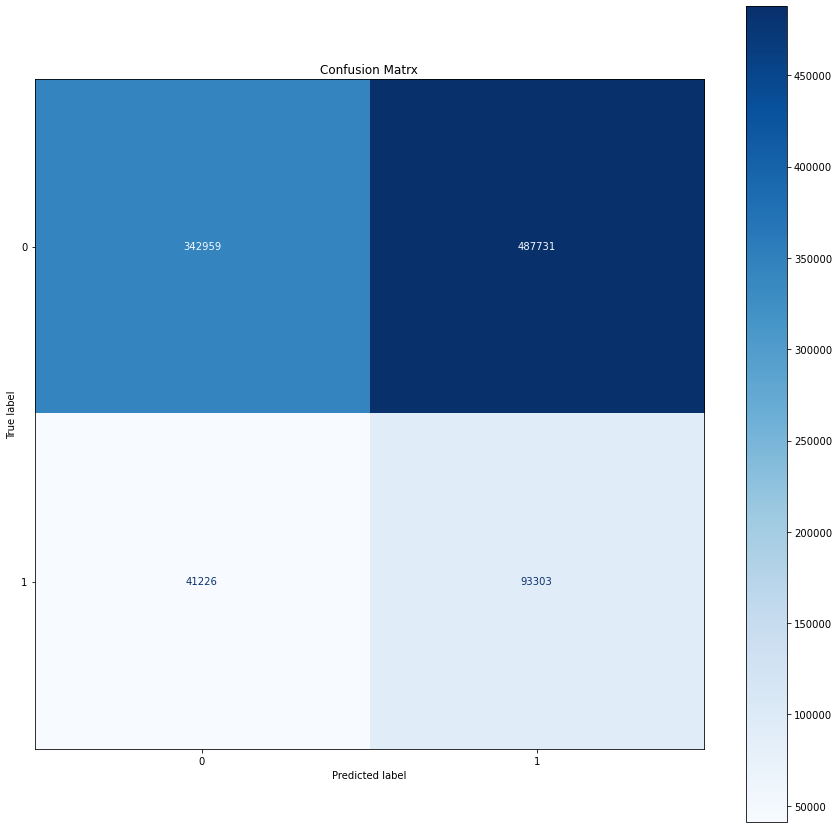

<Figure size 432x288 with 0 Axes>

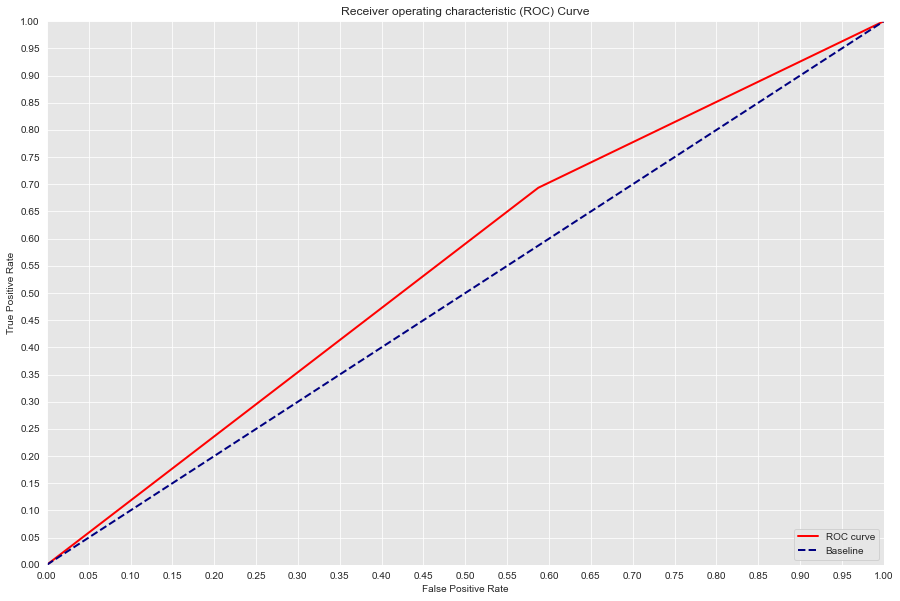

<Figure size 432x288 with 0 Axes>

In [41]:
preds = sclf.predict(processed_val)

# Print Testing accuracy
accuracy = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)
auc = roc_auc_score(y_val, preds)
print('\nTesting Accuracy: ', accuracy)
print('Testing f1 Score: ', f1)
print('Testing AUC Score: ', auc, '\n')

# print classification report
print(classification_report(y_val, preds))

# Visualize Confusion Matrix
print("\nConfusion Matrix for Test Set")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Confusion Matrx')
plot_confusion_matrix(sclf, processed_val, y_val, cmap=plt.cm.Blues, ax=ax)
plt.show()
plt.savefig('images/conf_matrix_overall.png')

# Get false positive, true positive, thresholds
fpr, tpr, thresholds = roc_curve(y_val, preds)

# Visualize AUC
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig('images/roc_overall.png')


# Model Evaluation

We score our model on F1 score rather than Accuracy. Accuracy is very easy to reach on this data - the model simply predicts very few delays when tuning and scoring on Accuracy. We would use accuracy if all classes are equally important. It's possible that the cost of a false negative is low in this instance, but the entire purpose of the model is to understand and predict a delay, so we will consider the cost of false negatives to be high.

Since want to minimize the number of False Negatives, so we use F1-Score instead, which is the harmonic mean of precision (reduce false positives where a delay was predicted and was not) and recall (reduce false negatives where a delay was not predicted and was delayed). This overall gives us a better measure of the incorrect classifications.

F1 is also considered a better metric when the set is highly imbalanced, for the simple reason that if based on Accuracy, the model may simply always predict for the majority class. In our situation, with a 80/20 imbalance, the model could easily achieve 80% accuracy by simply always prediction that a flight will not be delayed. This is not a useful prediction for us.

# APPENDIX

## Hyperparameter Tuning

Best roc_auc: 0.747
Best parameters set found on train set: 

{'depth': 9, 'iterations': 15000, 'learning_rate': 0.01}

### CatBoost

In [16]:
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]

cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=200, early_stopping_rounds=300, thread_count=4)

In [19]:
#Parameter Tuning

param_grid = {'depth':[5, 10],
          'iterations':[5000],
          'learning_rate':[.01, 0.05], 
          'l2_leaf_reg':[50, 150],
          'border_count':[32],
        'random_strength':[0,1],
        'bagging_temperature':[0,1],
          }


best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_train)
best_params

Making Search
Running Grid
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 169522
max_resources_: 4577104
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 169522
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 11
n_resources: 508566
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 2
n_candidates: 4
n_resources: 1525698
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 4577094
Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 0.6921402	total: 766ms	remaining: 1h 3m 50s
200:	learn: 0.6353276	total: 2m 9s	remaining: 51m 37s
400:	learn: 0.6272425	total: 4m 17s	remaining: 49m 16s
600:	learn: 0.6227700	total: 6m 25s	remaining: 47m 4s
800:	learn: 0.6196095	total: 8m 33s	remaining: 44m 52s
1000:	learn: 0.6171278	total: 10m 41s	remaining: 42m 43s
1200:	learn: 0.6149088	tot

{'bagging_temperature': 1,
 'border_count': 32,
 'depth': 10,
 'iterations': 5000,
 'l2_leaf_reg': 150,
 'learning_rate': 0.01,
 'random_strength': 0}

Best roc_auc: 0.736
Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 32, 'depth': 10, 'iterations': 5000, 'l2_leaf_reg': 150, 'learning_rate': 0.01, 'random_strength': 0}

In [27]:
#Parameter Tuning

param_grid = {'depth':[8, 10, 12],
          'iterations':[1000],
          'learning_rate':[.01], 
          'l2_leaf_reg':[150, 300],
          'border_count':[32, 255],
        'random_strength':[0],
        'bagging_temperature':[1],

          }

best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50856
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 50856
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 152568
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 457704
Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 0.6921339	total: 133ms	remaining: 2m 13s
200:	learn: 0.6337832	total: 26.7s	remaining: 1m 46s
400:	learn: 0.6243489	total: 53.7s	remaining: 1m 20s
600:	learn: 0.6184907	total: 1m 20s	remaining: 53.1s
800:	learn: 0.6137258	total: 1m 46s	remaining: 26.4s
999:	learn: 0.6099020	total: 2m 12s	remaining: 0us
Best roc_auc: 0.709
Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 150, 

{'bagging_temperature': 1,
 'border_count': 255,
 'depth': 10,
 'iterations': 1000,
 'l2_leaf_reg': 150,
 'learning_rate': 0.01,
 'random_strength': 0}

Best roc_auc: 0.709
Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 150, 'learning_rate': 0.01, 'random_strength': 0}


In [26]:
#Parameter Tuning

param_grid = {'depth':[10],
          'iterations':[1000, 5000, 15000],
          'learning_rate':[.01], 
          'l2_leaf_reg':[150],
          'border_count':[255],
        'random_strength':[1],
        'bagging_temperature':[1],
          }


best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 152570
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 152570
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 1
n_resources: 457710
Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.6921903	total: 133ms	remaining: 11m 3s
200:	learn: 0.6358097	total: 26.8s	remaining: 10m 40s
400:	learn: 0.6269035	total: 53.4s	remaining: 10m 12s
600:	learn: 0.6214620	total: 1m 21s	remaining: 9m 53s
800:	learn: 0.6173616	total: 1m 48s	remaining: 9m 26s
1000:	learn: 0.6137866	total: 2m 15s	remaining: 8m 59s
1200:	learn: 0.6106534	total: 2m 41s	remaining: 8m 32s
1400:	learn: 0.6074181	total: 3m 8s	remaining: 8m 4s
1600:	learn: 0.6042472	total: 3m 34s	remaining: 7m 36s
1800:	learn: 0.6011532	total: 4m 1s	remaining: 7m 8s
2000:	learn: 0.5986302	total: 4m 27s	remaining: 6m 41s


{'bagging_temperature': 1,
 'border_count': 255,
 'depth': 10,
 'iterations': 5000,
 'l2_leaf_reg': 150,
 'learning_rate': 0.01,
 'random_strength': 1}

Best roc_auc: 0.718
Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 10, 'iterations': 5000, 'l2_leaf_reg': 150, 'learning_rate': 0.01, 'random_strength': 1}

### XGBoost

In [24]:
#Parameter Tuning
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]


param_grid = {
            'eta': [.01, .03, .05],
            'gamma': [.1, 10],
            'max_depth': [10, 12, 14],
            'subsample': [.8, .9, .1],
            'min_child_weight': [1, 10],
            'n_estimators': [1000],
            'colsample_bytree' : [.5, .7, .9],
             }

xgbc = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=2, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist')

In [25]:
best_params = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 1883
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 324
n_resources: 1883
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 1
n_candidates: 108
n_resources: 5649
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 2
n_candidates: 36
n_resources: 16947
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 3
n_candidates: 12
n_resources: 50841
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 4
n_resources: 152523
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[12:24:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

{'colsample_bytree': 0.9,
 'eta': 0.01,
 'gamma': 10,
 'max_depth': 10,
 'min_child_weight': 10,
 'n_estimators': 1000,
 'subsample': 0.1}

Best roc_auc: 0.703
Best parameters set found on train set: 

{'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 10, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 1000, 'subsample': 0.1}

In [28]:
param_grid = {
            'eta': [.01],
            'gamma': [10, 50, 100],
            'max_depth': [8, 10],
            'subsample': [.1, .3],
            'min_child_weight': [10, 50],
            'n_estimators': [1000],
            'colsample_bytree' : [.9],
             }

best_params_2 = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params_2

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50856
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 50856
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 152568
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 457704
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[13:45:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best roc_auc: 0.715
Best parameters set found on train set: 

{'colsample_bytree': 0.9, 'eta

{'colsample_bytree': 0.9,
 'eta': 0.01,
 'gamma': 10,
 'max_depth': 10,
 'min_child_weight': 50,
 'n_estimators': 1000,
 'subsample': 0.3}

Best roc_auc: 0.715
Best parameters set found on train set: 

{'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 10, 'max_depth': 10, 'min_child_weight': 50, 'n_estimators': 1000, 'subsample': 0.3}

In [20]:
#Parameter Tuning
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]


param_grid = {
            'lambda': [1, 10],
            'alpha': [1, 10],    
            'max_delta_step': [1, 3],
            'num_parallel_tree': [10, 50],
             }

xgbc = xgb.XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=2, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = 10,
                        max_depth = 10,
                        subsample = .3,
                        min_child_weight = 50,
                        n_estimators = 1000,
                        col_sample_by_tree = .9)

In [21]:
best_params_2 = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params_2

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50856
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 50856
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 1
n_candidates: 6
n_resources: 152568
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 457704
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[16:48:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { col_sample_by_tree, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best roc_auc: 0.718
Best parameters set found on train set: 

{'alpha': 

{'alpha': 1, 'lambda': 1, 'max_delta_step': 3, 'num_parallel_tree': 10}

Best roc_auc: 0.718
Best parameters set found on train set: 

{'alpha': 1, 'lambda': 1, 'max_delta_step': 3, 'num_parallel_tree': 10}

### Logistic Regression

In [29]:
param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [1, 100],    
            'solver': ['liblinear'],
            'l1_ratio' : [1],
             }

param_grid3 = {
            'penalty': ['l2', 'elasticnet'],
            'C': [1, 100],    
            'solver': ['saga'],
            'l1_ratio' : [1],
             }


param_grid2 = {
            'penalty': ['l2'],
            'C': [1, 100],    
            'solver': ['lbfgs'],
            'l1_ratio' : [1],
             }

log_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1)

best_params = grid_optimizer(log_weighted, param_grid,  permutation_x_train, y_sample)
best_params2 = grid_optimizer(log_weighted, param_grid2,  permutation_x_train, y_sample)
best_params3 = grid_optimizer(log_weighted, param_grid3,  permutation_x_train, y_sample)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 152570
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 152570
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 457710
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best roc_auc: 0.667
Best parameters set found on train set: 

{'C': 100, 'l1_ratio': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Grid scores on train set:

0.666 (+/-0.004) for {'C': 1, 'l1_ratio': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.666 (+/-0.004) for {'C': 1, 'l1_ratio': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.666 (+/-0.004) for {'C': 100, 'l1_ratio': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.666 (+/-0.004) for {'C': 100, 'l1_ratio': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.667 (+/-0.003) for {'C': 100, 'l1_ratio': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.667

Best roc_auc: 0.667
Best parameters set found on train set: 

{'C': 100, 'l1_ratio': 1, 'penalty': 'l2', 'solver': 'liblinear'}

### Balanced Random Forest

In [33]:
param_grid = {
            'n_estimators': [1000],
            'criterion' : ['gini', 'entropy'],
            'max_depth': [10, None],
            'min_samples_split' : [2, 10],
            'min_samples_leaf': [1, 10],
            'max_features' : ['auto', 'sqrt', 'log2']

             }

bal_forest = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1, oob_score=True)

best_params = grid_optimizer(bal_forest, param_grid,  permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 16952
max_resources_: 457710
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 16952
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 16
n_resources: 50856
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 6
n_resources: 152568
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 457704
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best roc_auc: 0.697
Best parameters set found on train set: 

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

Grid scores on train set:

0.686 (+/-0.016) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_esti

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

Best roc_auc: 0.697
Best parameters set found on train set: 

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

# DEPRECATED

## Geovisual

In [ ]:
usa = gpd.read_file('shapefile/cb_2018_us_state_5m.shp')
usa

In [ ]:
# the heart of a geopandas data frame is visualization, and it is perfectly integrated to do that in a few lines. Here is King County

fig, ax = plt.subplots(figsize = (20,40))
usa.plot(ax=ax)
ax.set_title('King County',fontdict = {'fontsize': 30})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20});

In [ ]:
# Our map looks squat and ugly. We are going to figure out how to fix that. First let's check what kind of projection the data
# frame is using

usa.crs

In [ ]:
# We are changing our data into a mercator projection which is the standard world map-style projection that elongates latitude
# and will make the map look more the way we are used to

# Project the data into Mercator Projection epsg=3395
usa = king_county.to_crs({'init': 'epsg:3395'})


In [ ]:
final.groupby('DEPARTING_AIRPORT').mean()

In [ ]:
crs = {'init': 'epsg:4326'} # initiating my coordinate system
geometry = [Point(x,y) 
           for x,y in zip(df.long,df.lat)] # creating points
geo_df = gpd.GeoDataFrame(df, # the dataframe
                          crs = crs, # coordinate system that the data is using - lat/long uses the crs we initiated
                          geometry = geometry) # geometric points

# Project the coordinates into Mercator Projection epsg=3395 which is what we made our King County map into (otherwise
# our data points would not line up with our map properly)
geo_df_p = geo_df.to_crs({'init': 'epsg:3395'})

# looking at our data to get our quantiles for price
geo_df_p.describe()

# dividing our data into eight segments

first = geo_df_p[geo_df_p['price'] < 200000]
second = geo_df_p[(geo_df_p['price'] >= 200000) & (geo_df['price'] < 310000)]
third = geo_df_p[(geo_df_p['price'] >= 310000) & (geo_df['price'] < 370000)]
fourth = geo_df_p[(geo_df_p['price'] >= 370000) & (geo_df['price'] < 430000)]
fifth = geo_df_p[(geo_df_p['price'] >= 430000) & (geo_df['price'] < 515000)]
sixth = geo_df_p[(geo_df_p['price'] >= 515000) & (geo_df['price'] < 600000)]
seventh = geo_df_p[(geo_df_p['price'] >= 600000) & (geo_df['price'] < 710000)]
eighth = geo_df_p[geo_df_p['price'] >= 710000]

# plotting our quantiles on our map with increasing color depth for price

fig, ax = plt.subplots(figsize = (20,40))
ax.set_aspect(2)
king_county_projected.plot(ax=ax, alpha = 0.8, color = 'grey')

first.plot(ax = ax , markersize = 1, color = '#FFFFFF',marker = 'o',label = '<= 200k')
second.plot(ax = ax , markersize = 1, color = '#FFFFCC',marker = 'o',label = '200k to 310k')
third.plot(ax = ax , markersize = 1, color = '#FFFF00',marker = 'o',label = '310k to 370k')
fourth.plot(ax = ax , markersize = 1, color = '#FFB266',marker = 'o',label = '370k to 430k')
fifth.plot(ax = ax , markersize = 1, color = '#FF8000',marker = 'o',label = '430k to 515k')
sixth.plot(ax = ax , markersize = 1, color = '#FF0000',marker = 'o',label = '515k to 600k')
seventh.plot(ax = ax , markersize = 1, color = '#990000',marker = 'o',label = '600k to 710k')
eighth.plot(ax = ax , markersize = 1, color = '#000000',marker = 'o',label = '>= 710k')


plt.legend(prop = {'size':20} )

lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=20)
for handle in lgnd.legendHandles:
    handle.set_sizes([80.0])

ax.set_title('Home Sales in King County Metro Area', fontdict = {'fontsize':
                20})

ax.set_axis_off();

# save visualization to png
#plt.savefig('images/map_housing_dots.png');

In [ ]:
plt.figure(figsize=(30,20))
ax = plt.axes()
ax.set_facecolor("white")
sns.scale=2

sns.scatterplot(data=final, x="LONGITUDE", y="LATITUDE", hue="DEP_DEL15", palette="magma_r");